# Query domain reputation

## Introduction

- UUID: **e0af39c0-095b-4c31-9e42-2a731928c2a1**
- Started from [issue 13](https://github.com/MISP/misp-playbooks/issues/13)
- State: **Published** : demo version with **output**
- Purpose: This playbook queries the enabled OSINT feeds and the local MISP events for matches with one or more **domain name(s)**. 
- - The playbook also queries URLscan for historical scans related to the domains and extracts the screenshots from URLscan. The playbook then uses the MISP modules to look up the DNS resolutions and queries VirusTotal, Shodan and URLhaus for information related to the domains. You can also specify additional entries (indicators or elements to be used for querying these sources). 
- - The playbook also looks up the known abuse contacts via abuse_finder. All this information is then included in a summary and send to Mattermost and TheHive.
- Tags: [ "domain", "reputation" ]
- External resources: **URLscan**, **abuse_finder**, **DNS**, **URLhaus**, **Shodan**, **VirusTotal**, **Mattermost, TheHive**
- Target audience: **SOC, CSIRT, CTI**
- Graphical workflow 

![helpers/playbook-query_domain_reputation.png](helpers/playbook-query_domain_reputation.png)

# Playbook

- **Query domain reputation**
- - Introduction
- **Preparation**
- - PR:1 Initialise environment
- - PR:2 Verify MISP modules
- - PR:3 Load helper functions
- - PR:4 Set helper variables
- - PR:5 What are you searching for?
- - PR:6 MISP event details
- - PR:7 Setup MISP event link
- **Investigate**
- - IN:1 Context details for the domains
- - IN:2 Add the domains to the event
- **Correlation**
- - CR:1 Correlation with MISP events
- - CR:2 Correlation with MISP feeds
- **Enrichment**
- - ER:1 Enrich with information from URLscan
- - ER:2 Enrich with DNS information
- - ER:3 Enrich with abuse information
- - ER:4 Add custom enrichment information
- - ER:5 Review the current MISP event graph
- - ER:6 Enrich with information from VirusTotal
- - ER:7 Enrich with information from Shodan
- - ER:8 Enrich with information from URLhaus
- - ER:9 Add screenshots from URLscan to playbook
- - ER:10 Review and export final MISP event graph
- **Summary**
- - EN:1 MISP indicators
- - EN:2 Create the summary of the playbook
- - EN:3 Send a summary to Mattermost
- - EN:4 Send an alert to TheHive
- - EN:5 Publish MISP event
- - EN:6 End of the playbook
- External references
- Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Indicate if PyMISP should attempt to verify the certificate or ignore errors
urlscan_url="https://urlscan.io/api/v1/search"
urlscan_apikey="<URLSCAN API KEY>"
mattermost_playbook_user="<MATTERMOST USER>"
mattermost_hook="<MATTERMOST WEBHOOK>"
thehive_url="<THEHIVE URL>"
thehive_key="<THEHIVE API KEY>"
virustotal_apikey="<VIRUSTOTAL_APIKEY>"
shodan_apikey="<SHODAN_APIKEY>"
```

In [58]:
# Initialise Python environment
import urllib3
import sys
import json
import base64
import uuid
import time
import re
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from datetime import date
import requests
from pymisp import *
from pymisp.tools import GenericObjectGenerator
from abuse_finder import domain_abuse, ip_abuse, email_abuse, url_abuse
import textwrap

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Verify MISP modules

This playbook uses the MISP modules to obtain additional correlation or enrichment information. [MISP modules](https://github.com/MISP/misp-modules) are autonomous modules that can be used to extend MISP for new services such as expansion, import and export. The modules are written in Python 3 following a simple API interface. The objective is to ease the extensions of MISP functionalities without modifying core components. The API is available via a simple REST API which is independent from MISP installation or configuration.

In the next cell we check if we have access to the **MISP module** server and if the required modules are enabled.

In [2]:
# Where can we find the local MISP Module server? You can leave this to the default setting in most cases.
misp_modules_url = "http://127.0.0.1:6666"

# How long do we wait between queries when using the MISP modules (API rate limiting of external service such as VirusTotal)
misp_modules_wait = 3

# Initiliasation
misp_modules = {}
misp_modules_headers = {
    "Content-Type": "application/json",
    "Accept": "application/json"
}
misp_modules_in_use = ["dns", "virustotal_public", "shodan", "urlhaus"]
# Code block to query the MISP module server and check if our modules are enabled
res = requests.get("{}/modules".format(misp_modules_url), headers=misp_modules_headers)
for module in res.json():
    for module_requested in misp_modules_in_use:
        if module.get("name", False) == module_requested:
            misp_modules[module_requested] = {"enabled": True, "input": module.get("mispattributes").get("input")}
            print("Found the \033[92m{}\033[90m MISP module (Accepted input: {}).".format(module_requested, misp_modules[module_requested]["input"]))
print("\n\n")

Found the dns MISP module (Accepted input: ['hostname', 'domain', 'domain|ip']).
Found the shodan MISP module (Accepted input: ['ip-src', 'ip-dst']).
Found the urlhaus MISP module (Accepted input: ['domain', 'hostname', 'ip-src', 'ip-dst', 'md5', 'sha256', 'url']).
Found the virustotal_public MISP module (Accepted input: ['hostname', 'domain', 'ip-src', 'ip-dst', 'md5', 'sha1', 'sha256', 'url']).





## PR:3 Load helper functions

The next cell contains **helper functions** that are used in this playbook. 

Instead of distributing helper functions as separate Python files this playbook includes all the required code as one code cell. This makes portability of playbooks between instances easier. The downside is that functions defined in this playbook need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration of playbooks it is chosen to include the code in the playbook (more portability), but you can easily create one "helper" file that contains all the helper code and then import that file in each playbook (for example by adding to the previous cell `from helpers import *`). Note that the graphical workflow image is included as an external image. A missing image would not influence the further progress of the playbook.

To avoid cluttering the output of the playbook the next code cell is **collapsed**. You still **need to execute it**, but you can leave the cell collapsed. Click on the cell to expand it, click on the left bar that indicates the active cell in the Jupyter notebook to collapse it again.

In [3]:
def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
    misp_tags = []
    for el in tags:
        t = MISPTag()
        t.name = el
        t.local = False
        misp_tags.append(t)

    for el in local_tags:
        t = MISPTag()
        t.name = el
        t.local = True
        misp_tags.append(t)
    return misp_tags


def pb_add_enrichment(playbook_results, field, entry, key, value):
    '''
    Add an enrichment (or correlation) entry but first check that the value is not already there
    
    : param playbook_results: all the enrichment results
    : param field
    : param entry
    : param key
    : param value
    '''
    skip_field = False
    for existing_entry in playbook_results.get(field, []):
        if existing_entry.get(key, False) == value:
            skip_field = True
            print(" Not adding to playbook results because of duplicate. Already added via {}".format(existing_entry.get("source", False)))
    if not skip_field:
        if field in playbook_results:
            playbook_results[field].append(entry)
        else:
            playbook_results[field] = [entry]
    return playbook_results


print("\033[92mHelper functions loaded\033[90m.\n\n".format(misp_url))

Helper functions loaded.




## PR:4 Set helper variables

This cell contains **helper variables** that are used in this playbook. Their usage is explained in the next steps of the playbook.

In [4]:
# Dictionary to playbook results and some of the core objects that are created
playbook_results = {}
case_objects = {}

# A set of regular expressions that we use to determine the attribute type
regular_expressions = {"sha256": "^[a-fA-F0-9]{64}$",
                       "md5": "^[a-fA-F0-9]{32}$",
                       "hostname": "^[a-zA-Z0-9.\-_]+\.[a-zA-Z]{2,}$",
                       "sha1": "^[a-fA-F0-9]{40}$",
                       "url": "^(http|https):\/\/[-a-zA-Z0-9-]{2,256}\.[-a-zA-Z0-9-]{2,256}",
                       "ip-src": "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}",
                       "ip-dst": "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
                      }

# Variables to hold the output tables. Can also be moved to a dictionary
table_customentries = None
table_mispevents = None
table_mispfeeds = None
table_urlscan = None
table_dns = None
table_abuse = None
table_virustotal = None
table_shodan = None
table_urlhaus = None

## PR:5 What are you searching for?

In this section you can define your **user input** as the **domains** that you want to investigate with this playbook. The variable `query_domain` can contain one domain (a 'string') or a list of domains.

The input to this cell is <font color='red'>crucial for the further progress</font> of this playbook.

In [5]:
# Provide one or more domain names
query_domain = ["qwepoi123098.com", "mikeylinehan.com"]

In [6]:
# Simple function to make a list. Makes it more consistent to work with the user input in the next cells.
if type(query_domain) == str:
    query_domain =[query_domain]
print("The playbook will do the domain reputation query for \033[92m{}\033[90m\n".format(query_domain))

The playbook will do the domain reputation query for ['qwepoi123098.com', 'mikeylinehan.com']



## PR:6 MISP event details

### Event title

In this playbook we create a **new** MISP event with title **Domain reputation investigation for _domainlist_**. You get the chance to override this default title but remember that it is good practice to choose a self-explanatory **event title**. This event title is shown in the MISP event index and should provide you the necessary information what the event is about. You should avoid using generic event titles. Read the [Best Practices in Threat Intelligence](https://www.misp-project.org/best-practices-in-threat-intelligence.html) for further guidance.

### Contexualisation

This playbook adds event contexualisation via the **tags** that are defined in `event_additional_global_tags` (for *global* tags) and `event_additional_local_tags` (for *local* tags). As a reminder, whereas *global* tags remain attached to the events that you share with your community, the *local* tags are not shared outside your organisation. It's also a good idea to primarily use tags that are part of a [taxonomy](https://github.com/MISP/misp-taxonomies), this allows you to make the contexualisation more portable accross multiple MISP instances.

In this playbook the list of tags is build via one of the helper functions `pb_get_misp_tags`. This function takes two arguments, first a list of tags to convert as *global* tags, and secondly a list of tags to convert as *local* tags. It then returns a Python list of MISPTag objects.

### Traffic Light Protocol

The default **TLP** for this event is **<span style='color:#FFBF00'>tlp:amber</span>**. The Traffic Light Protocol (TLP) facilitates sharing of potentially sensitive information and allows for more effective collaboration. TLP is a set of four standard labels to indicate the sharing boundaries to be applied by the recipients. TLP is always set by the creator of information. You can find more information at [FIRST](https://www.first.org/tlp/). You can specify the TLP via `event_tlp`.

### MISP Galaxies

This playbook can also add MISP galaxies to the event with the variable `event_galaxies`. A common galaxy is for example [T1583/001](https://attack.mitre.org/techniques/T1583/001/). You can also leave the list empty if you do not want to add galaxies in this stage of the investigation.

### MISP distribution, threat level and analysis level

Optionally you can specifiy a MISP **distribution** (with `event_distribution`), **threat level** (with `event_threat_level_id`) or **analysis state** (with `event_analysis`). The event **date** is set to today via `event_date`.

If you cannot remember the options for distribution, threat level or the analysis state then use the next cell to guide you. This cell is set as **raw**. If you **change its type to code** and execute the cell you get an overview of the options available for creating a MISP event.

## PR:7 Setup MISP event link

By default the playbook will generate a **title** with a prefix and the domains you want to investigate. You can override this event title with the variable `event_title`. If you leave this value empty the playbook will generate the MISP event title for you.

In [7]:
# Provide the event title for a new event. Leave blank for the playbook to auto generate one
event_title = ""

# Prefix for auto generate event title
event_title_default_prefix = "Domain reputation investigation"

# Optionally, you can change TLP, add additional event (local and global) tags, threatlevel, analysis state or distribution level
event_tlp = "tlp:amber"

# Event context
event_additional_global_tags = []                                 # This needs to be a Python list
event_additional_local_tags = ["workflow:state=\"incomplete\""]   # This needs to be a Python list

# Event galaxies
event_galaxies = ["misp-galaxy:mitre-attack-pattern=\"Domains - T1583.001\""]

# Additional MISP event settings
event_threat_level_id = ThreatLevel.low
event_analysis = Analysis.ongoing
event_distribution = Distribution.your_organisation_only
event_date = date.today()

### Create MISP event

The next code cell will **create the MISP event** and store the references to the newly created event in the variable `misp_event`. This variable is used further when the playbook progresses.

In [8]:
# Code block to create the event or add data to an existing event
event_title = event_title.strip()

if not(event_title is str and len(event_title) > 0):
    event_title = "{} for {}".format(event_title_default_prefix, ' '.join(query_domain))

# Construct the event tags
event_additional_global_tags.append(event_tlp)
event_additional_global_tags.append(event_galaxies)
event_tags = pb_get_misp_tags(event_additional_global_tags, event_additional_local_tags)

# Create the PyMISP object for an event
event = MISPEvent()
event.info = event_title
event.distribution = event_distribution
event.threat_level_id = event_threat_level_id
event.analysis = event_analysis
event.set_date(event_date)

# Create the MISP event on the server side
misp_event = misp.add_event(event, pythonify=True)
print("Continue the playbook with the new \033[92mcreated\033[90m MISP event ID {} with title \033[92m{}\033[90m and UUID {}".format(misp_event.id, misp_event.info, misp_event.uuid))
for tag in event_tags:
    misp.tag(misp_event.uuid, tag, local=tag.local)
    print("\033[92mAdded\033[90m event tag {}".format(tag))
print("\n\n")

Continue the playbook with the new created MISP event ID 2653 with title Domain reputation investigation for qwepoi123098.com mikeylinehan.com and UUID d8a4e911-6d65-4076-b563-76dcdf4ce0cf
Added event tag <MISPTag(name=tlp:amber)>
Added event tag <MISPTag(name=['misp-galaxy:mitre-attack-pattern="Domains - T1583.001"'])>
Added event tag <MISPTag(name=workflow:state="incomplete")>





# Investigate

## IN:1 Context details for the domains

In this section you can set the context details (tags) for the (domain) attributes via the variable `attribute_tags`. These tags are used when the domains are added as an object to the MISP event.

In [9]:
attribute_tags = pb_get_misp_tags(["PAP:GREEN", "course-of-action:passive=\"discover\""])

## IN:2 Add the domains to the event

Before we query the MISP events or the external data sources we first add the domains that are under investigation as `domain-ip` objects to our events.

In [10]:
for domain in query_domain:
    domain_object = MISPObject("domain-ip")
    domain_object.add_attribute("domain", domain, tags=attribute_tags, comment="Added by playbook")
    result = misp.add_object(misp_event.uuid, domain_object, pythonify=True)
    if not "errors" in result:
        case_objects[domain] = result
        playbook_results[domain] = []
        print("\033[92mAdded\033[90m object for {} with UUID {}".format(domain, result.uuid))
    else:
        print(result)
print("\n")

Added object for qwepoi123098.com with UUID a7a25778-311f-497a-8cde-5f3391337bca
Added object for mikeylinehan.com with UUID 2d534b25-47d9-4a8f-a14d-51838e5a09b5




# Correlation

## CR:1 Correlation with MISP events

This cell searches the **MISP server** for events that have a match with one of the domains previously specified. A summary of the correlation is also shown at the end of the playbook.

Only **published** events (`correlation_published`) and attributes that have the **to_ids** flag (`correlation_to_ids`) set are take into account. There is a default limit of **1000 hits** (`correlation_limit`) and you can limit the search with tags (`correlation_match_tags`).

In [11]:
# Only query for published MISP events
correlation_published = True

# Only consider those values that have the to_ids field set to True
correlation_to_ids = True

# Limit the returned results to 1000 attributes
correlation_limit = 1000

# Only return results corresponding with these tags
correlation_match_tags = ["tlp:amber", "tlp:white"]

In [12]:
# Code block to query MISP and find the correlations
if len(query_domain) > 0:
    search_match = misp.search("attributes", to_ids=correlation_to_ids, value=query_domain, tags=correlation_match_tags,
                                   published=correlation_published, limit=correlation_limit, pythonify=True)
    if len(search_match) > 0:
        for attribute in search_match:
            if attribute.Event.id != misp_event.id:   # Skip the event we just created for this playbook
                print("Found \033[92m{}\033[90m in \033[92m{}\033[90m".format(attribute.value, attribute.Event.info))
                entry = {"source": "MISP", "category": attribute.category, "type": attribute.type, "event_id": attribute.Event.id, "event_info": attribute.Event.info, "enriched": attribute.value}
                playbook_results = pb_add_enrichment(playbook_results, attribute.value, entry, "event_id", attribute.Event.id)
        print("\n")
    else:
        print("\033[93mNo correlating MISP events found")
else:
    print("\033[93mNo correlating MISP events found")

Found mikeylinehan.com in M2M -  GlobeImposter "..doc" 2018-01-12 : "Unpaid invoice " - "1234567.7z"
Found qwepoi123098.com in CrowdStrike Falcon Platform Detects and Prevents Active Intrusion Campaign Targeting 3CXDesktopApp Customers




### MISP events correlation table

The correlation results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [13]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Event", "Event ID"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Event"] = "l"
table.align["Event ID"] = "l"
table._max_width = {"Event": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "MISP":
            table.add_row([match["source"], domain, match["category"], match["type"], match["event_info"], match["event_id"]])
print(table.get_string(sortby="Value"))
table_mispevents = table

+--------+------------------+------------------+----------+----------------------------------------------------+----------+
| Source | Value            | Category         | Type     | Event                                              | Event ID |
+--------+------------------+------------------+----------+----------------------------------------------------+----------+
|  MISP  | mikeylinehan.com | Network activity | hostname | M2M -  GlobeImposter "..doc" 2018-01-12 : "Unpaid  | 2051     |
|        |                  |                  |          | invoice " - "1234567.7z"                           |          |
|  MISP  | qwepoi123098.com | Network activity | domain   | CrowdStrike Falcon Platform Detects and Prevents   | 2540     |
|        |                  |                  |          | Active Intrusion Campaign Targeting 3CXDesktopApp  |          |
|        |                  |                  |          | Customers                                          |          |
+-------

## CR:2 Correlation with MISP feeds

This cell searches the **MISP feeds** for events that have a match with the domains you specified in `query_domain`. The output of this cell is a table with all the matches. The output is also repeated at the end of the playbook.

Note that the correlation lookup in the MISP feeds does not return the name of the MISP event, it returns the UUID of the event as title.

In [14]:
if len(query_domain) > 0:
    misp_cache_url = "{}/feeds/searchCaches/".format(misp_url)
    match = False
    for domain in query_domain:
        # Instead of GET, use POST (https://github.com/MISP/MISP/issues/7478)
        cache_results = requests.post(misp_cache_url, headers=misp_headers, verify=misp_verifycert, json={"value": domain})
        for result in cache_results.json():
            if "Feed" in result:
                match = True
                print("Found \033[92m{}\033[90m in \033[92m{}\033[90m".format(domain, result["Feed"]["name"]))
                for match in result["Feed"]["direct_urls"]:
                    entry = {"source": "Feeds", "feed_name": result["Feed"]["name"], "match_url": match["url"]}
                    playbook_results = pb_add_enrichment(playbook_results, domain, entry, "match_url", match["url"])
    if not match:
        print("\033[93mNo correlating information found in MISP feeds.\n\n")
else:
    print("\033[93mNo correlating information found in MISP feeds.\n\n")

Found mikeylinehan.com in CIRCL OSINT Feed


### MISP feed correlations table

The correlation results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [15]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Feed", "URL"]
table.align["Value"] = "l"
table.align["Feed"] = "l"
table.align["Feed URL"] = "l"
table._max_width = {"Feed": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "Feeds":
            table.add_row([match["source"], domain, match["feed_name"], match["match_url"]])
print(table.get_string(sortby="Value"))
table_mispfeeds = table

+--------+------------------+------------------+---------------------------------------------------------------------------------------+
| Source | Value            | Feed             |                                          URL                                          |
+--------+------------------+------------------+---------------------------------------------------------------------------------------+
| Feeds  | mikeylinehan.com | CIRCL OSINT Feed | https://misp.demo.cudeso.be/feeds/previewEvent/1/5a607314-de88-4309-ba06-c4a9950d210f |
+--------+------------------+------------------+---------------------------------------------------------------------------------------+


# Enrichment

## ER:1 Enrich with information from URLscan

### URLscan

This section queries [URLscan.io](https://urlscan.io/) for scan results of the **domains** that are under investigation. Note that there is also a [MISP enrichment module for URLscan](https://github.com/MISP/misp-modules/blob/main/misp_modules/modules/expansion/urlscan.py) but that module is not used in this playbook. This playbook required more flexibility in handling the results from URLscan.

### Query time

Note that execution of this cell takes a couple of seconds. 

In [16]:
# Code block to query URLscan
replace_urlscan = ["+", "-", "=", "&&", "||", ">", "<", "!", "(", ")", "{", "}", "[", "]", "^", "~", "*", "?", ":", "/"]
module_source = "URLscan.io"
comment_default = "From {}".format(module_source)
for domain in query_domain:
    domain = domain.strip()
    for k in replace_urlscan:
        domain = domain.replace(k, "\{}".format(k))      # Required by URLscan to avoid errors in the submit
    enrichment = []
    headers = {"API-Key": urlscan_apikey, "Content-Type": "application/json", "Cache-Control": "no-cache"}
    result = requests.get("{}/?q=domain:{}".format(urlscan_url, domain), headers=headers)

    if result.status_code == 200 and result.json().get("total") > 0:
        print("Received {} URLscan results for \033[92m{}\033[90m".format(result.json().get("total"), domain))
        for el in result.json().get("results"):
            screenshot_data = requests.get(el["screenshot"])
            enrichment.append({
                    "url": el["page"]["url"],
                    "ip": el["page"].get("ip", False),
                    "server": el["page"].get("server", "Unknown").strip(),
                    "title": el["page"].get("title", "").strip(),
                    "result": el["result"],
                    "screenshot": el["screenshot"],
                    "screenshot_data": screenshot_data,
                    "time": el["task"].get("time", False),
                    "umbrellaRank": el["page"].get("umbrellaRank", False)
            })

        for enriched in enrichment:
            b_screenshot_data = False
            if "url" in enriched:
                print(" Got analysis result for \033[92m{}\033[90m".format(enriched["url"]))
                entry = {"source": module_source, "category": "Network activity", "type": "url", "enriched": enriched["url"]}
                playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", enriched["url"])
                url_object = MISPObject("url")
                url_object.add_attribute("url", enriched["url"], comment=comment_default)
                url_object.comment = "{} {}".format(comment_default, enriched["result"])
                if "time" in enriched:
                    url_object.last_seen = enriched["time"]
                    url_object.first_seen = enriched["time"]
                    url_object.add_attribute("first-seen", enriched["time"], comment=comment_default)
                    url_object.add_attribute("last-seen", enriched["time"], comment=comment_default)
                if "title" in enriched and enriched["title"]:
                    url_object.add_attribute("text", enriched["title"], comment=comment_default)
                if "ip" in enriched and enriched["ip"]:
                    url_object.add_attribute("ip", enriched["ip"], comment=comment_default)
                    print(" Got \033[92m{}\033[90m".format(enriched["ip"]))
                    entry = {"source": module_source, "category": "Network activity", "type": "ip-dst", "enriched": enriched["ip"]}
                    playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", enriched["ip"])
                url_object_misp = misp.add_object(misp_event.uuid, url_object, pythonify=True)
                if not "errors" in url_object_misp:
                    misp.add_object_reference(url_object_misp.add_reference(case_objects[domain].uuid, "linked-to"))
                    if enriched["url"] not in case_objects:
                        case_objects[enriched["url"]] = url_object_misp                    
                else:
                    print(url_object_misp)

                if "screenshot" in enriched:
                    b_screenshot_data = base64.b64encode(enriched["screenshot_data"].content).decode('utf-8')
                    attribute = MISPAttribute()
                    attribute.value = "screenshot-{}-{}".format(domain, enriched["screenshot"].split("screenshots/")[1])
                    attribute.to_ids = False
                    attribute.type = "attachment"
                    attribute.disable_correlation = True
                    attribute.comment = comment_default
                    screenshot_time = ""
                    if "time" in enriched:
                        attribute.last_seen = enriched["time"]
                        attribute.first_seen = enriched["time"]
                        screenshot_time = enriched["time"]
                    attribute.data = b_screenshot_data
                    attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)                    
                    entry = {"source": module_source, "screenshot_url": enriched["url"], "screenshot_urlscan": enriched["screenshot"], "screenshot_name": attribute.value, "screenshot": b_screenshot_data, "screenshot_time": screenshot_time}
                    playbook_results = pb_add_enrichment(playbook_results, domain, entry, "screenshot", b_screenshot_data)
                    if not "errors" in attribute_misp:
                        misp.add_object_reference(url_object_misp.add_reference(attribute_misp.uuid, "screenshot-of"))
                    else:
                        print(attribute_misp)

                if "server" in enriched and enriched["server"] and enriched["server"] not in ["Unknown"]:
                    already_there = misp.search("attributes", value="server: {}".format(enriched["server"]), uuid=misp_event.uuid, to_ids=False, type="comment", category="Other", limit=1, pythonify=True)
                    if len(already_there) < 1:
                        attribute = MISPAttribute()
                        attribute.category = "Other"
                        attribute.type = "comment"
                        attribute.value = "server: {}".format(enriched["server"])
                        attribute.to_ids = False
                        attribute.disable_correlation = False
                        attribute.comment = comment_default
                        if "time" in enriched:
                            attribute.last_seen = enriched["time"]
                            attribute.first_seen = enriched["time"]
                        attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        entry = {"source": module_source, "category": "Other", "type": "server", "enriched": enriched["server"]}
                        playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", enriched["server"])
                    else:
                        attribute_misp = already_there[0]
                    if not "errors" in attribute_misp:
                        misp.add_object_reference(url_object_misp.add_reference(attribute_misp.uuid, "related-to"))
                    else:
                        print(attribute_misp)
                        
                if "umbrellaRank" in enriched and enriched["umbrellaRank"]:
                    already_there = misp.search("attributes", value="umbrellaRank: {}".format(enriched["umbrellaRank"]), uuid=misp_event.uuid, to_ids=False, type="text", category="External analysis", limit=1, pythonify=True)
                    if len(already_there) < 1:
                        attribute = MISPAttribute()
                        attribute.category = "External analysis"
                        attribute.type = "text"
                        attribute.value = "umbrellaRank: {}".format(enriched["umbrellaRank"])
                        attribute.to_ids = False
                        attribute.disable_correlation = False
                        attribute.comment = comment_default
                        if "time" in enriched:
                            attribute.last_seen = enriched["time"]
                            attribute.first_seen = enriched["time"]
                        attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                        entry = {"source": module_source, "category": "Other", "type": "umbrellaRank", "enriched": enriched["umbrellaRank"]}
                        playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", enriched["umbrellaRank"])
                    else:
                        attribute_misp = already_there[0]
                    if not "errors" in attribute_misp:
                        misp.add_object_reference(url_object_misp.add_reference(attribute_misp.uuid, "ranked-with"))
                    else:
                        print(attribute_misp)

print("Finished URLscan enrichment.\n\n")

Received 8 URLscan results for qwepoi123098.com
 Got analysis result for http://qwepoi123098.com/
 Got 50.116.17.41
 Got analysis result for https://qwepoi123098.com/
 Got analysis result for https://qwepoi123098.com/
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Got analysis result for http://qwepoi123098.com/
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Got 50.116.17.41
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Got analysis result for http://qwepoi123098.com/
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Got 104.194.215.229
 Got analysis result for http://qwepoi123098.com/
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Got 104.194

### URLscan enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

This playbook has the "enrichment" code and the "table" code in two different code cells. Although this requires you to execute two code cells, it provides you the advantage of being to print out the table, without having to go through the entire enrichment code again. This table returns only those matches corresponding with the source **URLscan.io**.

In [17]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "URLscan.io":
            if "category" in match and "type" in match:
                table.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
            elif "screenshot_name" in match:
                table.add_row([match["source"], domain, "", "screenshot", "{} for {}".format(match["screenshot_name"], match["screenshot_url"])])
print(table.get_string(sortby="Value"))
table_urlscan = table

+------------+------------------+------------------+--------------+----------------------------------------------------+
|   Source   | Value            | Category         | Type         | Enriched                                           |
+------------+------------------+------------------+--------------+----------------------------------------------------+
| URLscan.io | mikeylinehan.com |                  | screenshot   | screenshot-mikeylinehan.com-083df698-5833-403d-86c |
|            |                  |                  |              | 9-c831d88efd79.png for                             |
|            |                  |                  |              | http://mikeylinehan.com/kjdfhg874                  |
| URLscan.io | mikeylinehan.com |                  | screenshot   | screenshot-mikeylinehan.com-5078b872-1baa-41be-a2d |
|            |                  |                  |              | 4-55d097ebc0ef.png for http://mikeylinehan.com/    |
| URLscan.io | mikeylinehan.com 

## ER:2 Enrich with DNS information

The next cell will query the MISP DNS module and add the DNS resolution result as a MISP `domain-ip` object. This new object is also linked to the domain via a relation `resolves-to`. The resulting IP addresses can later be used by the VirusTotal and other MISP modules for enrichment.

This module uses the default DNS resolver defined in the MISP module (8.8.8.8) but you can also specify your own DNS server with `module_dnsserver`.

In [18]:
# DNS server to use. Leave blank to use 8.8.8.8 (default MISP module)
module_dnsserver = ""

In [19]:
module_name = "dns"
module_source = "DNS"
module_comment = "From {}".format(module_source)

if misp_modules[module_name]["enabled"] and len(query_domain) > 0:
    for value in query_domain:
        attribute_type = "domain"
        data = {
            "domain": f"{value}",
            "module": module_name
        }
        if len(module_dnsserver) > 0:
            data["config"] = { "nameserver": module_dnsserver }
        print("Query \033[92m{}\033[90m".format(value))
        result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
        #pprint(result.json())
        if "results" in result.json() and len(result.json()["results"]) > 0:
            result_json = result.json()["results"]
            for entry in result_json:
                if "values" in entry:
                    for module_value in entry["values"]:
                        ip_object = MISPObject("domain-ip")
                        ip_object.add_attribute("ip", module_value, comment=module_comment)
                        ip_object_misp = misp.add_object(misp_event.uuid, ip_object, pythonify=True)
                        if not "errors" in ip_object_misp:
                            case_objects[module_value] = ip_object_misp
                            misp.add_object_reference(case_objects[value].add_reference(ip_object_misp.uuid, "resolves-to"))
                            print(" Got \033[92m{}\033[90m".format(module_value))
                            entry = {"source": module_source, "category": "Network activity", "type": "ip-dst", "enriched": module_value}
                            playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", module_value)

print("Finished DNS enrichment.\n\n")

Query qwepoi123098.com
 Got 50.116.17.41
Query mikeylinehan.com
Finished DNS enrichment.




### DNS enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

This table returns only those matches corresponding with the source **DNS**.

In [20]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "DNS":
            table.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
print(table.get_string(sortby="Value"))
table_dns = table

+--------+------------------+------------------+--------+--------------+
| Source | Value            | Category         | Type   | Enriched     |
+--------+------------------+------------------+--------+--------------+
|  DNS   | mikeylinehan.com | Network activity | ip-dst | 50.116.17.41 |
+--------+------------------+------------------+--------+--------------+


## ER:3 Enrich with abuse information

The next cell uses the [abuse_finder](https://github.com/certsocietegenerale/abuse_finder) information to get the most appropriate contact details for abuse reports. These contain details are also added as MISP attributes, either `whois-registrant-name` or `whois-registrant-email`.

The first cell will look up the details for the **domains**. The second cell looks up the details for the **IP addresses**.

Optionally you can specify the relationship type with the variable `relationtype` (by default it is `associated-with`).

In [21]:
# Relationship type for abuse records
relationtype = "associated-with"

In [22]:
module_source = "abuse_finder"
module_comment = "From {}".format(module_source)

# Lookup abuse details for the domains
for domain in query_domain:
    print("Trying \033[92m{}\033[90m".format(domain))
    details = domain_abuse(domain)
    if "names" in details:
        attribute_category = "Attribution"
        attribute_type = "whois-registrant-name"
        for name in details["names"]:
            print(" Got \033[92m{}\033[90m".format(name))
            entry = {"source": module_source, "category": attribute_category, "type": attribute_type, "enriched": name}
            playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", name)
            
            attribute = MISPAttribute()
            attribute.value = name
            attribute.to_ids = False
            attribute.category = attribute_category
            attribute.type = attribute_type
            attribute.disable_correlation = True
            attribute.comment = "{}. Information for {}".format(module_comment, domain)
            attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
            if not "errors" in attribute_misp:
                misp.add_object_reference(case_objects[domain].add_reference(attribute_misp.uuid, relationtype))
            else:
                print(attribute_misp)
    if "abuse" in details:
        attribute_category = "Attribution"
        attribute_type = "whois-registrant-email"
        for name in details["abuse"]:
            print(" Got \033[92m{}\033[90m".format(name))
            entry = {"source": module_source, "category": "Attribution", "type": "whois-registrant-email", "enriched": name}
            playbook_results = pb_add_enrichment(playbook_results, domain, entry, "enriched", name)

            attribute = MISPAttribute()
            attribute.value = name
            attribute.to_ids = False
            attribute.category = attribute_category
            attribute.type = attribute_type
            attribute.disable_correlation = True
            attribute.comment = "{}. Information for {}".format(module_comment, domain)
            attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
            if not "errors" in attribute_misp:
                misp.add_object_reference(case_objects[domain].add_reference(attribute_misp.uuid, relationtype))
            else:
                print(attribute_misp)
        
print("Finished abuse_finder enrichment for domains.\n\n")

Trying qwepoi123098.com
 Got NameCheap, Inc.
 Got abuse@namecheap.com
Trying mikeylinehan.com
Finished abuse_finder enrichment for domains.




In [23]:
# Lookup abuse details for the IP addresses
for ip in case_objects:
    if re.match(r"{}".format(regular_expressions["ip-dst"]), ip):
        print("Trying \033[92m{}\033[90m".format(ip))
        details = ip_abuse(ip)
        if "names" in details:
            attribute_category = "Attribution"
            attribute_type = "whois-registrant-name"
            for name in details["names"]:
                print(" Got \033[92m{}\033[90m".format(name))
                entry = {"source": module_source, "category": attribute_category, "type": attribute_type, "enriched": name}
                playbook_results = pb_add_enrichment(playbook_results, ip, entry, "enriched", name)

                attribute = MISPAttribute()
                attribute.value = name
                attribute.to_ids = False
                attribute.category = attribute_category
                attribute.type = attribute_type
                attribute.disable_correlation = True
                attribute.comment = "{}. Information for {}".format(module_comment, ip)
                attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                if not "errors" in attribute_misp:
                    misp.add_object_reference(case_objects[ip].add_reference(attribute_misp.uuid, relationtype))
                else:
                    print(attribute_misp)
        if "abuse" in details:
            attribute_category = "Attribution"
            attribute_type = "whois-registrant-email"
            for name in details["abuse"]:
                print(" Got \033[92m{}\033[90m".format(name))
                entry = {"source": module_source, "category": "Attribution", "type": "whois-registrant-email", "enriched": name}
                playbook_results = pb_add_enrichment(playbook_results, ip, entry, "enriched", name)

                attribute = MISPAttribute()
                attribute.value = name
                attribute.to_ids = False
                attribute.category = attribute_category
                attribute.type = attribute_type
                attribute.disable_correlation = True
                attribute.comment = "{}. Information for {}".format(module_comment, ip)
                attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
                if not "errors" in attribute_misp:
                    misp.add_object_reference(case_objects[ip].add_reference(attribute_misp.uuid, relationtype))
                else:
                    print(attribute_misp)

print("Finished abuse_finder enrichment for IPs.\n\n")

Trying 50.116.17.41
 Got Akamai Technologies, Inc.
 Got Linode
 Got abuse@akamai.com
 Got abuse@linode.com
Finished abuse_finder enrichment for IPs.




### Abuse information enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

This table returns only those matches corresponding with the source **abuse_finder**.

In [24]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "abuse_finder":
            table.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
print(table.get_string(sortby="Value"))
table_abuse = table

+--------------+------------------+-------------+------------------------+---------------------------+
|    Source    | Value            | Category    | Type                   | Enriched                  |
+--------------+------------------+-------------+------------------------+---------------------------+
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-email | abuse@akamai.com          |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-email | abuse@linode.com          |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-name  | Akamai Technologies, Inc. |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-name  | Linode                    |
| abuse_finder | qwepoi123098.com | Attribution | whois-registrant-email | abuse@namecheap.com       |
| abuse_finder | qwepoi123098.com | Attribution | whois-registrant-name  | NameCheap, Inc.           |
+--------------+------------------+-------------+------------------------

## ER:4 Add custom enrichment information

The next cells query VirusTotal, Shodan and URLhaus for additional enrichments. This is done with the list of domains you provided earlier (via `query_domain`) but also (optionally) on the results of DNS resolution. But before we get to that you can also add **additional entries** that need to be investigated by the next *enrichment* cells. 

You can add these entries now as custom enrichment information. Obviously you can also use them to add additional indicators that you found relevant for your investigation.

You first have to define the **domain** that the information is related to with `custom_entry_domain` and set the enrichment **category** `custom_entry_category`, **type** `custom_entry_type` and **value** `custom_entry_value`. If you leave `custom_entry_value` empty then the code execution is skipped and no additional entries are added. You can add multiple values by re-executing the next two cells multiple times.

Optionally you can also specify the relation type (with `custom_entry_relation`), set the to_ids value (with `custom_entry_to_ids`) and provide a comment (with `custom_entry_comment`).

To provide you some help the next cell prints out the domains you supplied earlier via query_domains. You can use that as input for the `custom_entry_domain` in the cell for adding custom enrichment information.

In [25]:
# Print an overview of the domains this playbook works with
count = 0
for domain in query_domain:
    print("{} = {}".format(count, domain))
    count += 1

0 = qwepoi123098.com
1 = mikeylinehan.com


In [26]:
# To which domain do you want the enrichment to link
custom_entry_domain = query_domain[0] # (or provide the domain directly)

# What's the MISP category and type
custom_entry_category = "Payload delivery"
custom_entry_type = "md5"

# Custom value
custom_entry_value = "44d88612fea8a8f36de82e1278abb02f" # For example MD5 of EICAR

# Define the relation ship type
custom_entry_relation = "linked-to"

# Do you want to have the to_ids field enabled when adding it the attribute to MISP?
custom_entry_to_ids = True

# Comment field for additional entry
custom_entry_comment = "EICAR hash"

In [27]:
if len(custom_entry_value.strip()) > 0:
    # Set the custom enrichment
    entry = {"source":"Custom", "category": custom_entry_category, "type": custom_entry_type, "enriched": custom_entry_value}
    playbook_results = pb_add_enrichment(playbook_results, custom_entry_domain, entry, "enriched", entry["enriched"])

    # Add to MISP
    attribute = MISPAttribute()
    attribute.value = custom_entry_value
    attribute.to_ids = custom_entry_to_ids
    attribute.category = custom_entry_category
    attribute.type = custom_entry_type
    attribute.comment = "Added as custom enrichment - {}".format(custom_entry_comment)
    attribute_misp = misp.add_attribute(misp_event.uuid, attribute, pythonify=True)
    if not "errors" in attribute_misp:
        print("Attribute \033[92m{}\033[90m added\n".format(attribute_misp.uuid))
        misp.add_object_reference(case_objects[custom_entry_domain].add_reference(attribute_misp.uuid, custom_entry_relation))
        if not table_customentries:
            table_customentries = PrettyTable()
            table_customentries.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
            table_customentries.align["Value"] = "l"
            table_customentries.align["Category"] = "l"
            table_customentries.align["Type"] = "l"
            table_customentries.align["Enriched"] = "l"
            table_customentries._max_width = {"Enriched": 50}
        for domain in playbook_results:
            for match in playbook_results[domain]:
                if match["source"] == "Custom":
                    table_customentries.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
    else:
        print(attribute_misp)
        print("Attribute \033[91mnot added\033[90m\n")

Attribute a8088495-1975-42ce-bc76-2273f901fca4 added



## ER:5 Review the current MISP event graph

The MISP event graph allows you to get a visualisation of the relationships between different objects and attributes. At this stage of the investigation it can already be useful to have a look at the current graph. It should contain the relations for the **domain** objects, the **URL** objects received from URLscan but also the **DNS**, **abuse information** and **custom** enrichment information.

You can access the event graph by logging in to MISP, viewing the details of the newly created event and then using the **Event graph** tab. While you are reviewing the event graph it can also be useful to have a look at the **correlation** graph.

![helpers/playbook-query_domain_reputation_eventgraph.png](helpers/playbook-query_domain_reputation_eventgraph.png)

![helpers/playbook-query_domain_reputation_correlationgraph.png](helpers/playbook-query_domain_reputation_correlationgraph.png)

## ER:6 Enrich with information from VirusTotal

If the **VirusTotal** module is enabled in MISP modules you can now query VirusTotal. 

By default the playbook will query VirusTotal for results related to the original domains you specified as input in the first section of the playbook. But you can extend this list via `virustotal_include_enrichment`. Be aware that some attributes (such as IPs) can create a lot of additional attributes when the domain points to a shared hosting facility.

You can also ignore results that are returned by VirusTotal with `virustotal_skip_enrichment_result`.

And finally you can also indicate if you want to keep the to_ids value set by the VirusTotal module or always set it to False (`virustotal_to_ids`). The latter is advised. If you set `virustotal_to_ids` to True, then the playbook keeps the value returned by the VirusTotal module.

In [28]:
# In addition to the domains, query VirusTotal for the below enrichment values
# Beware of IPs pointing to hosting facilities
#virustotal_include_enrichment = []
virustotal_include_enrichment = ["ip-dst"]
#virustotal_include_enrichment = ["ip-dst", "url", "domain", "whois-registrant-email"]

# Do not include related URLs returned by VirusTotal. For some domains this can result a large result set
virustotal_result_skip_enrichment_result = ["url", "domain"]

# to_ids: False: always set to False ; True: keep what's returned by the MISP module
virustotal_to_ids = False

In [29]:
# Code block to query VirusTotal
vt_query = []
for domain in query_domain:
    if re.match(r"{}".format(regular_expressions["hostname"]), domain):
        vt_query.append(domain)

for domain in playbook_results:
    for element in playbook_results[domain]:
        if element.get("type", False) in virustotal_include_enrichment and len(element["enriched"]) > 0 and element["enriched"] not in vt_query:
            vt_query.append(element["enriched"])

# Code block to query VirusTotal
module_name = "virustotal_public"
module_source = "VirusTotal"
if misp_modules[module_name]["enabled"]:
    for value in vt_query:
        module_comment = "From {} for {}".format(module_source, value)
        for expr in regular_expressions:
            if re.match(r"{}".format(regular_expressions[expr]), value):
                attribute_type = expr
                break

        if attribute_type in misp_modules[module_name]["input"]:
            data = {
                "attribute": {
                    "type": f"{attribute_type}",
                    "uuid": str(uuid.uuid4()),
                    "value": f"{value}",
                },
                "module": module_name,
                "config": {"apikey": virustotal_apikey}
            }
            print("Query \033[92m{}\033[90m as \033[92m{}\033[90m".format(value, attribute_type))
            result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
            if "results" in result.json() and len(result.json()["results"]) > 0:
                result_json = result.json()["results"]
                for misp_attribute in result_json.get("Attribute", []):
                    if misp_attribute["type"] in virustotal_result_skip_enrichment_result:
                        print(" Skip {} \033[96m{}\033[90m".format(misp_attribute["type"], misp_attribute["value"]))
                        continue
                    else:
                        del misp_attribute["uuid"]
                        misp_attribute["comment"] = "{}{}".format(module_comment, misp_attribute.get("comment", ""))
                        if misp_attribute["to_ids"] == True and not virustotal_to_ids:
                            misp_attribute["to_ids"] = False
                        try:
                            created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
                            if not "errors" in created_attribute:
                                if value in case_objects:
                                    misp.add_object_reference(case_objects[value].add_reference(created_attribute.uuid, "related-to"))
                                print(" Got {} \033[92m{}\033[90m".format(misp_attribute["type"], misp_attribute["value"]))
                                entry = {"source": module_source, "category": misp_attribute["category"], "type": misp_attribute["type"], "enriched": misp_attribute["value"]}
                                playbook_results = pb_add_enrichment(playbook_results, value, entry, "enriched", misp_attribute["value"])
                        except:
                            print(" Unable to add {} \033[92m{}\033[90m to MISP event".format(misp_attribute["type"], misp_attribute["value"]))

                for misp_object in result_json.get("Object", []):
                    if misp_object["name"] in virustotal_result_skip_enrichment_result:
                        print(" Skip {}".format(misp_object["name"]))
                        continue
                    else:
                        del misp_object["uuid"]
                        misp_object["comment"] = "{}{}".format(module_comment, misp_object.get("comment", ""))
                        new_attribute_list = []
                        for attribute in misp_object.get("Attribute", []):
                            if attribute["type"] in virustotal_result_skip_enrichment_result:
                                print(" Skip {} \033[96m{}\033[90m".format(attribute["type"], attribute["value"]))
                            else:
                                if attribute["to_ids"] == True and not virustotal_to_ids:
                                    attribute["to_ids"] = False
                                attribute["comment"] = module_comment
                                new_attribute_list.append(attribute)
                        misp_object["Attribute"] = new_attribute_list
                        if len(misp_object["Attribute"]) > 0:
                            created_object = misp.add_object(misp_event.uuid, misp_object, pythonify=True)
                            if not "errors" in created_object:
                                if value in case_objects:
                                    misp.add_object_reference(case_objects[value].add_reference(created_object.uuid, "related-to"))
                                if misp_object["name"] == "whois":
                                    whois_attributes = misp_object.get("Attribute", [])
                                    for whois_attribute in whois_attributes:
                                        print(" Got whois data for \033[92m{}\033[90m ".format(domain))
                                        entry = {"source": module_source, "category": "Other", "type": "whois", "enriched": whois_attribute["value"]}
                                        playbook_results = pb_add_enrichment(playbook_results, value, entry, "enriched", whois_attribute["value"])
                                else:
                                    if misp_object["name"] == "domain-ip":
                                        for attribute in misp_object.get("Attribute",[]):
                                            if attribute["type"] == "ip-dst":
                                                if attribute["value"] not in case_objects:
                                                    case_objects[attribute["value"]] = created_object
                                    for misp_attribute in misp_object["Attribute"]:
                                        print(" Got {} \033[92m{}\033[90m as part of object {}".format(misp_attribute["type"], misp_attribute["value"], misp_object["name"]))
                                        entry = {"source": module_source, "category": misp_attribute["category"], "type": misp_attribute["type"], "enriched": misp_attribute["value"]}
                                        playbook_results = pb_add_enrichment(playbook_results, value, entry, "enriched", misp_attribute["value"])

            print("Sleeping for {} seconds".format(misp_modules_wait))
            time.sleep(misp_modules_wait)
        else:
            print("Skipping \033[91m{}\033[90m. Not a valid query type ({}).".format(value, misp_modules[module_name]["input"]))

print("Finished VirusTotal enrichment.\n\n")

Query qwepoi123098.com as hostname
 Got sha256 2b6282da522f1f51ee6e0ed5e37aa55a191d34ffbb3c287cb20d71ad2bf25b4b
 Got sha256 ce7127c38e30e92a021ed2bd09287713c6a923db9ffdb43f126e8965d777fbf0
 Skip domain www.qwepoi123098.com
 Skip url https://qwepoi123098.com/
 Skip url http://qwepoi123098.com/
 Got whois data for 50.116.17.41 
 Skip domain qwepoi123098.com
 Got ip-dst 104.194.215.229 as part of object domain-ip
 Not adding to playbook results because of duplicate. Already added via URLscan.io
 Got ip-dst 139.162.120.150 as part of object domain-ip
 Got ip-dst 146.70.87.109 as part of object domain-ip
 Got ip-dst 50.116.17.41 as part of object domain-ip
 Not adding to playbook results because of duplicate. Already added via URLscan.io
Sleeping for 3 seconds
Query mikeylinehan.com as hostname
 Got sha256 51c93eda00d090aae0d3e211fb1679aa6456df7dc51a7cd45bf4d3b990b531c7
 Got sha256 69fb7b96d2da05f2aef88efc9e788ede343c9112ae164fe026e504449d56464e
 Got sha256 86749d3e3233d7a75a618c98eac9f31f5

Something went wrong (403): {'saved': False, 'name': 'Could not add Attribute', 'message': 'Could not add Attribute', 'url': '/attributes/add', 'errors': {'value': ['A similar attribute already exists for this event.']}}


 Got sha256 5596dc862bd9aea2981ebe1f8a638557d1383ccd9a47c94c9610300325f94a0e
 Got sha256 77795c8a3c5a8ff8129cb4db828828c53a590f93583fcfb0b1112a4e670c97d4
 Got sha256 c45ef4a35047e14d8eaf54cab44a432be18e93915ac26a2f1294d260f220aea8
 Got sha256 103d93ab0996ed79df9184183fb63f3c37c2fbd0aa505174e29256ddf02208b5
 Skip domain www.mikeylinehan.com
 Skip url https://mikeylinehan.com/
 Skip url http://mikeylinehan.com/wp-content/uploads/2017/11/0ML0211_0ML0211-R1-E012.jpg
 Skip url http://mikeylinehan.com/wp-content/uploads/2017/10/16779837_10211211562552145_141027329_n.jpg
 Skip url http://mikeylinehan.com/wp-content/uploads/2017/10/20597623_330257494090980_248941076_o.jpg
 Skip url http://mikeylinehan.com/wp-content/themes/avata/options-framework/assets/css/hoo-styles.css
 Skip url http://mikeylinehan.com/wp-includes/wlwmanifest.xml
 Skip url http://mikeylinehan.com/kjdfhg874
 Skip url http://mikeylinehan.com/wp-content/uploads/2017/10/19549566_313330345783695_504397474_o.jpg
 Skip url http://

### VirusTotal enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

This table returns only those matches corresponding with the source **VirusTotal**.

In [30]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "VirusTotal":
            table.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
print(table.get_string(sortby="Value"))
table_virustotal = table

+------------+------------------+------------------+--------+----------------------------------------------------+
|   Source   | Value            | Category         | Type   | Enriched                                           |
+------------+------------------+------------------+--------+----------------------------------------------------+
| VirusTotal | 104.194.215.229  | Network activity | AS     | 8100                                               |
| VirusTotal | 104.194.215.229  | Network activity | ip-dst | 104.194.215.229                                    |
| VirusTotal | 104.194.215.229  | Other            | text   | US                                                 |
| VirusTotal | 199.188.200.96   | Network activity | AS     | 22612                                              |
| VirusTotal | 199.188.200.96   | Network activity | ip-dst | 199.188.200.96                                     |
| VirusTotal | 199.188.200.96   | Other            | text   | US                

## ER:7 Enrich with information from Shodan

If the **Shodan** module is enabled in MISP modules you can now query Shodan. 

By default the playbook will query Shodan for results related to the original domains you specified as input in the first section of the playbook. But you can extend this list via `shodan_include_enrichment`. Be aware that some attributes (such as IPs) can create a lot of additional attributes when the domain points to a shared hosting facility.

You can also ignore additional results returned by Shodan with `shodan_result_skip_category_type`. This variable is a Python list containing a combination of MISP category and type (format: `category/type`) that you do not want to include the summary and event.

And finally you can also indicate if you want to keep the to_ids value set by the Shodan module or always set it to False (`shodan_to_ids`). The latter is advised. If you set `shodan_to_ids` to True, then the playbook keeps the value returned by the Shodan module.

In [31]:
# In addition to the domains, query Shodan for the below enrichment values
# Beware of IPs pointing to hosting facilities. Note that the MISP Shodan module only accepts IPs as input
shodan_include_enrichment = ["ip-dst"]
#shodan_include_enrichment = []

# Do not include category_type of the below returned by Shodan. For some domains this can result a large result set
shodan_result_skip_category_type = ["Other/text", "Other/float", "Other/datetime", "Network activity/port", "External analysis/link"]

# to_ids: False: always set to False ; True: keep what's returned by the MISP module
shodan_to_ids = False

In [32]:
# Code block to query Shodan
shodan_query = []
for domain in query_domain:
    if re.match(r"{}".format(regular_expressions["hostname"]), domain):
        shodan_query.append(domain)

for domain in playbook_results:
    for element in playbook_results[domain]:
        if element.get("type", False) in shodan_include_enrichment and len(element["enriched"]) > 0 and element["enriched"] not in shodan_query:
            shodan_query.append(element["enriched"])

# Code block to query Shodan
module_name = "shodan"
module_source = "Shodan"
if misp_modules[module_name]["enabled"]:
    for value in shodan_query:
        module_comment = "From {} for {}".format(module_source, value)
        attribute_type = False
        for expr in regular_expressions:
            if re.match(r"{}".format(regular_expressions[expr]), value):
                attribute_type = expr
                break

        if attribute_type in misp_modules[module_name]["input"]:
            data = {
                "attribute": {
                    "type": f"{attribute_type}",
                    "uuid": str(uuid.uuid4()),
                    "value": f"{value}",
                },
                "module": module_name,
                "config": {"apikey": shodan_apikey}
            }
            print("Query \033[92m{}\033[90m as \033[92m{}\033[90m".format(value, attribute_type))
            result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
            #pprint(result.json())
            if "results" in result.json() and len(result.json()["results"]) > 0:
                result_json = result.json()["results"]
                for misp_object in result_json["Object"]:
                    misp_object["comment"] = "{}{}".format(module_comment, misp_object.get("comment", ""))
                    new_attribute_list = []
                    for misp_attribute in misp_object.get("Attribute", []):
                        category_type = "{}/{}".format(misp_attribute["category"], misp_attribute["type"])
                        if category_type not in shodan_result_skip_category_type:
                            if misp_attribute["to_ids"] == True and not shodan_to_ids:
                                misp_attribute["to_ids"] = False
                            entry = {"source": module_source, "category": misp_attribute["category"], "type": misp_attribute["type"], "enriched": misp_attribute["value"]}
                            playbook_results = pb_add_enrichment(playbook_results, value, entry, "enriched", misp_attribute["value"])
                            misp_attribute["comment"] = module_comment
                            new_attribute_list.append(misp_attribute)
                            print(" Got {} {} as part of object {}".format(misp_attribute["type"], misp_attribute["value"], misp_object["name"]))
                    misp_object["Attribute"] = new_attribute_list
                    if len(misp_object["Attribute"]) > 0:
                        created_object = misp.add_object(misp_event.uuid, misp_object, pythonify=True)
                        if not "errors" in created_object:
                            if value in case_objects:
                                misp.add_object_reference(case_objects[value].add_reference(created_object.uuid, "related-to"))
            print("Sleeping for {} seconds".format(misp_modules_wait))
            time.sleep(misp_modules_wait)
        else:
            print("Skipping \033[91m{}\033[90m. Not a valid query type ({}).".format(value, misp_modules[module_name]["input"]))

print("Finished Shodan enrichment.\n\n")

Skipping qwepoi123098.com. Not a valid query type (['ip-src', 'ip-dst']).
Skipping mikeylinehan.com. Not a valid query type (['ip-src', 'ip-dst']).
Query 50.116.17.41 as ip-src
 Got AS AS63949 as part of object ip-api-address
 Not adding to playbook results because of duplicate. Already added via VirusTotal
 Got ip-src 50.116.17.41 as part of object ip-api-address
 Not adding to playbook results because of duplicate. Already added via VirusTotal
 Got ip-src 50.116.17.41 as part of object ip-port
 Got domain linode.com as part of object ip-port
 Got hostname li601-41.members.linode.com as part of object ip-port
 Got x509-fingerprint-sha256 70435e54dd434ae295a76cd0bb98375c7162e66c69a7b92bf79cfe29bff32ad5 as part of object x509
 Got x509-fingerprint-sha1 306654bab3f48527a550b23c2b7a2d9431fc2ff8 as part of object x509
Sleeping for 3 seconds
Query 104.194.215.229 as ip-src
 Got AS AS8100 as part of object ip-api-address
 Not adding to playbook results because of duplicate. Already added via

### Shodan enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

This table returns only those matches corresponding with the source **Shodan**.

In [33]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "Shodan":
            table.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
print(table.get_string(sortby="Value"))
table_shodan = table

+--------+-----------------+-------------------+-------------------------+----------------------------------------------------+
| Source | Value           | Category          | Type                    | Enriched                                           |
+--------+-----------------+-------------------+-------------------------+----------------------------------------------------+
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2016-10002                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2016-10003                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-1000024                                   |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-1000027                                   |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-19131               

## ER:8 Enrich with information from URLhaus

If the **URLhaus** module is enabled in MISP modules you can now query URLhaus. 

By default the playbook will query URLhaus for results related to the original domains you specified as input in the first section of the playbook. But you can extend this list via `urlhaus_include_enrichment`. Be aware that some attributes (such as IPs) can create a lot of additional attributes when the domain points to a shared hosting facility.

You can also ignore additional results returned by URLhaus with `urlhaus_result_skip_category_type`. This variable is a Python list containing a combination of MISP category and type (format: `category/type`) that you do not want to include the summary and event.

And finally you can also indicate if you want to keep the to_ids value set by the URLhaus module or always set it to False (`urlhaus_to_ids`). The latter is advised. If you set `urlhaus_to_ids` to True, then the playbook keeps the value returned by the URLhaus module.

In [34]:
# In addition to the domains, query URLhaus for the below enrichment values
# Beware of IPs pointing to hosting facilities.
#urlhaus_include_enrichment = []
urlhaus_include_enrichment = ["ip-src", "domain", "md5", "sha256"]

# Do not include category_type of the below returned by URLhaus. For some domains this can result a large result set
urlhaus_result_skip_category_type = ["Other/text", "Other/float", "Other/datetime", "Network activity/port", "External analysis/link"]

# to_ids: False: always set to False ; True: keep what's returned by the MISP module
urlhaus_to_ids = False

In [35]:
# Code block to query URLhaus
urlhaus_query = []
for domain in query_domain:
    if re.match(r"{}".format(regular_expressions["hostname"]), domain):
        urlhaus_query.append(domain)
for domain in playbook_results:
    for element in playbook_results[domain]:
        if element.get("type", False) in urlhaus_include_enrichment and len(element["enriched"]) > 0 and element["enriched"] not in urlhaus_query:
            urlhaus_query.append(element["enriched"])

# Code block to query URLHaus
module_name = "urlhaus"
module_source = "URLhaus"
if misp_modules[module_name]["enabled"] and len(urlhaus_query) > 0:
    for value in urlhaus_query:
        module_comment = "From {} for {}".format(module_source, value)
        attribute_type = False
        for expr in regular_expressions:
            if re.match(r"{}".format(regular_expressions[expr]), value):
                attribute_type = expr
                break

        if attribute_type in misp_modules[module_name]["input"]:
            data = {
                "attribute": {
                    "type": f"{attribute_type}",
                    "uuid": str(uuid.uuid4()),
                    "value": f"{value}",
                },
                "module": module_name,
            }
            print("Query \033[92m{}\033[90m as \033[92m{}\033[90m".format(value, attribute_type))
            result = requests.post("{}/query".format(misp_modules_url), headers=misp_modules_headers, json=data)
            if "results" in result.json() and len(result.json()["results"]) > 0:
                result_json = result.json()["results"]

                for misp_attribute in result_json.get("Attribute", []):
                    del misp_attribute["uuid"]
                    misp_attribute["comment"] = "{}{}".format(module_comment, misp_attribute.get("comment", ""))
                    if misp_attribute["to_ids"] == True and not urlhaus_to_ids:
                        misp_attribute["to_ids"] = False
                    try:
                        created_attribute = misp.add_attribute(misp_event.uuid, misp_attribute, pythonify=True)
                        if not "errors" in created_attribute:
                            if value in case_objects:
                                misp.add_object_reference(case_objects[value].add_reference(created_attribute.uuid, "related-to"))
                            print(" Got {} {}".format(misp_attribute["type"], misp_attribute["value"]))
                            entry = {"source": module_source, "category": misp_attribute["category"], "type": misp_attribute["type"], "enriched": misp_attribute["value"]}
                            playbook_results = pb_add_enrichment(playbook_results, value, entry, "enriched", misp_attribute["value"])
                    except:
                        print(" Unable to add {} {} to MISP event".format(misp_attribute["type"], misp_attribute["value"]))

                for misp_object in result_json.get("Object", []):
                    del misp_object["uuid"]
                    misp_object["comment"] = "{}{}".format(module_comment, misp_object.get("comment", ""))
                    new_attribute_list = []
                    for attribute in misp_object.get("Attribute", []):
                        attribute["comment"] = module_comment
                        if attribute["to_ids"] == True and not urlhaus_to_ids:
                            attribute["to_ids"] = False
                        new_attribute_list.append(attribute)
                    misp_object["Attribute"] = new_attribute_list
                    created_object = misp.add_object(misp_event.uuid, misp_object, pythonify=True)
                    if not "errors" in created_object:
                        if value in case_objects:
                            misp.add_object_reference(case_objects[value].add_reference(created_object.uuid, "related-to"))

            print("Sleeping for {} seconds".format(misp_modules_wait))
            time.sleep(misp_modules_wait)
        else:
            print("Skipping \033[91m{}\033[90m. Not a valid query type ({}).".format(value, misp_modules[module_name]["input"]))

print("Finished URLhaus enrichment.\n\n")

Query qwepoi123098.com as hostname
Sleeping for 3 seconds
Query mikeylinehan.com as hostname
Sleeping for 3 seconds
Query 44d88612fea8a8f36de82e1278abb02f as md5
Sleeping for 3 seconds
Query 2b6282da522f1f51ee6e0ed5e37aa55a191d34ffbb3c287cb20d71ad2bf25b4b as sha256
Sleeping for 3 seconds
Query ce7127c38e30e92a021ed2bd09287713c6a923db9ffdb43f126e8965d777fbf0 as sha256
Sleeping for 3 seconds
Query 51c93eda00d090aae0d3e211fb1679aa6456df7dc51a7cd45bf4d3b990b531c7 as sha256
Sleeping for 3 seconds
Query 69fb7b96d2da05f2aef88efc9e788ede343c9112ae164fe026e504449d56464e as sha256
Sleeping for 3 seconds
Query 86749d3e3233d7a75a618c98eac9f31f508aed4492849f65b907787b0bd1d047 as sha256
Sleeping for 3 seconds
Query 75d6289e33dbf05543f8a850e40c7bb3e3f8b9e2872015f8a7b09906aabb7b5e as sha256
Sleeping for 3 seconds
Query 5596dc862bd9aea2981ebe1f8a638557d1383ccd9a47c94c9610300325f94a0e as sha256
Sleeping for 3 seconds
Query 77795c8a3c5a8ff8129cb4db828828c53a590f93583fcfb0b1112a4e670c97d4 as sha256
Sleepi

### URLhaus enrichment table

The results are now stored in `playbook_results`. Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

This table returns only those matches corresponding with the source **URLhaus**.

In [36]:
# Put the correlations in a pretty table. We can use this table later also for the summary
table = PrettyTable()
table.field_names = ["Source", "Value", "Category", "Type", "Enriched"]
table.align["Value"] = "l"
table.align["Category"] = "l"
table.align["Type"] = "l"
table.align["Enriched"] = "l"
table._max_width = {"Enriched": 50}
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "URLhaus":
            table.add_row([match["source"], domain, match["category"], match["type"], match["enriched"]])
print(table.get_string(sortby="Value"))
table_urlhaus = table

+--------+-------+----------+------+----------+
| Source | Value | Category | Type | Enriched |
+--------+-------+----------+------+----------+
+--------+-------+----------+------+----------+


## ER:9 Add screenshots from URLscan to playbook

This section displays the screenshots retrieved earlier from URLscan. 

You can use the screenshots for a visual verification of the URLs without the need to visit them in a sandbox. All these screenshots are also **added to the MISP event** and link to the URL objects.

If you want to skip this step then don't execute the next cell. Not executing the cell has no negative impact on the progress of the playbook.

http://qwepoi123098.com/ for qwepoi123098.com at 2023-04-26T13:52:44.555Z


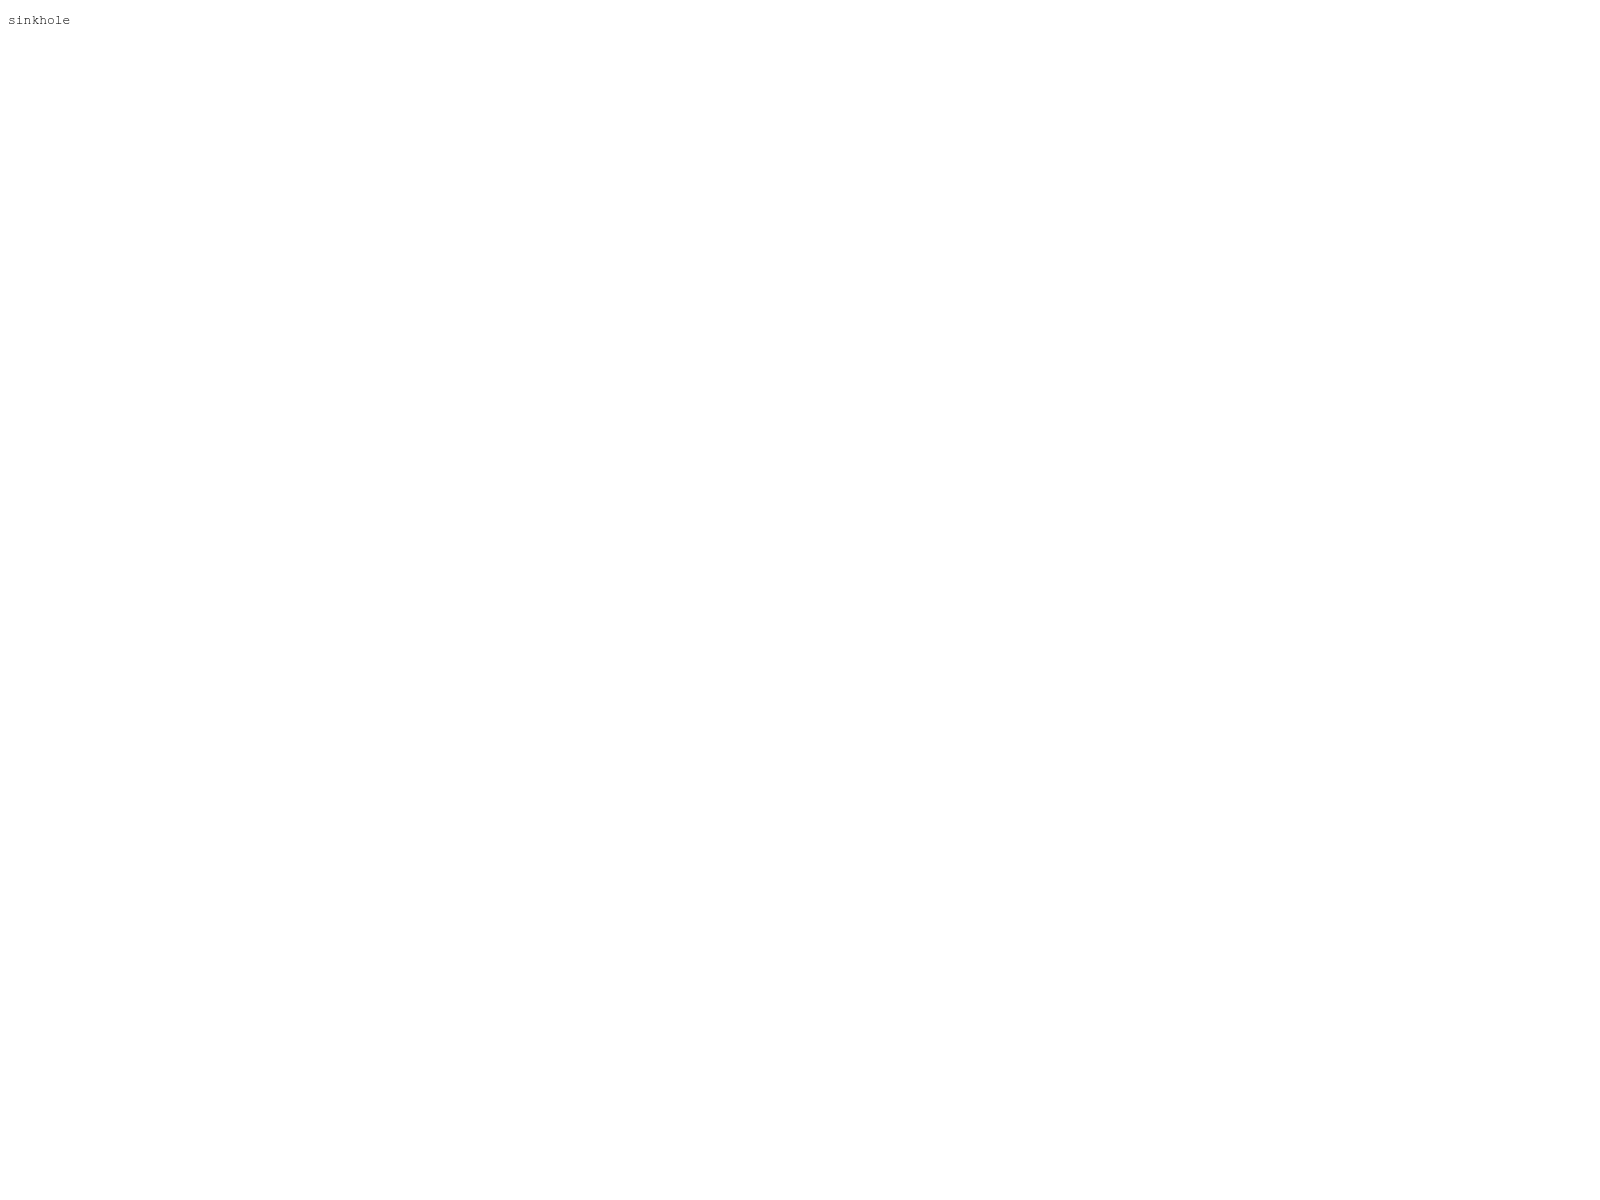



https://qwepoi123098.com/ for qwepoi123098.com at 2023-04-26T02:27:22.838Z


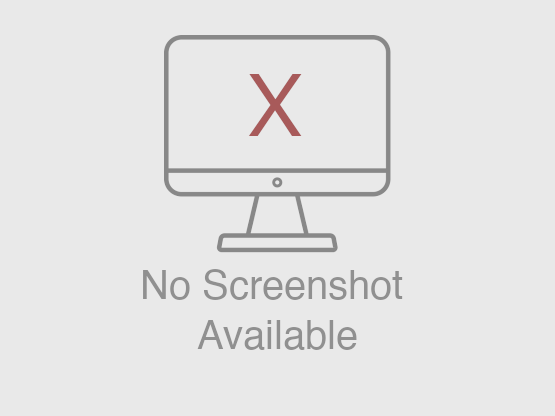



http://qwepoi123098.com/ for qwepoi123098.com at 2023-03-29T21:54:44.992Z


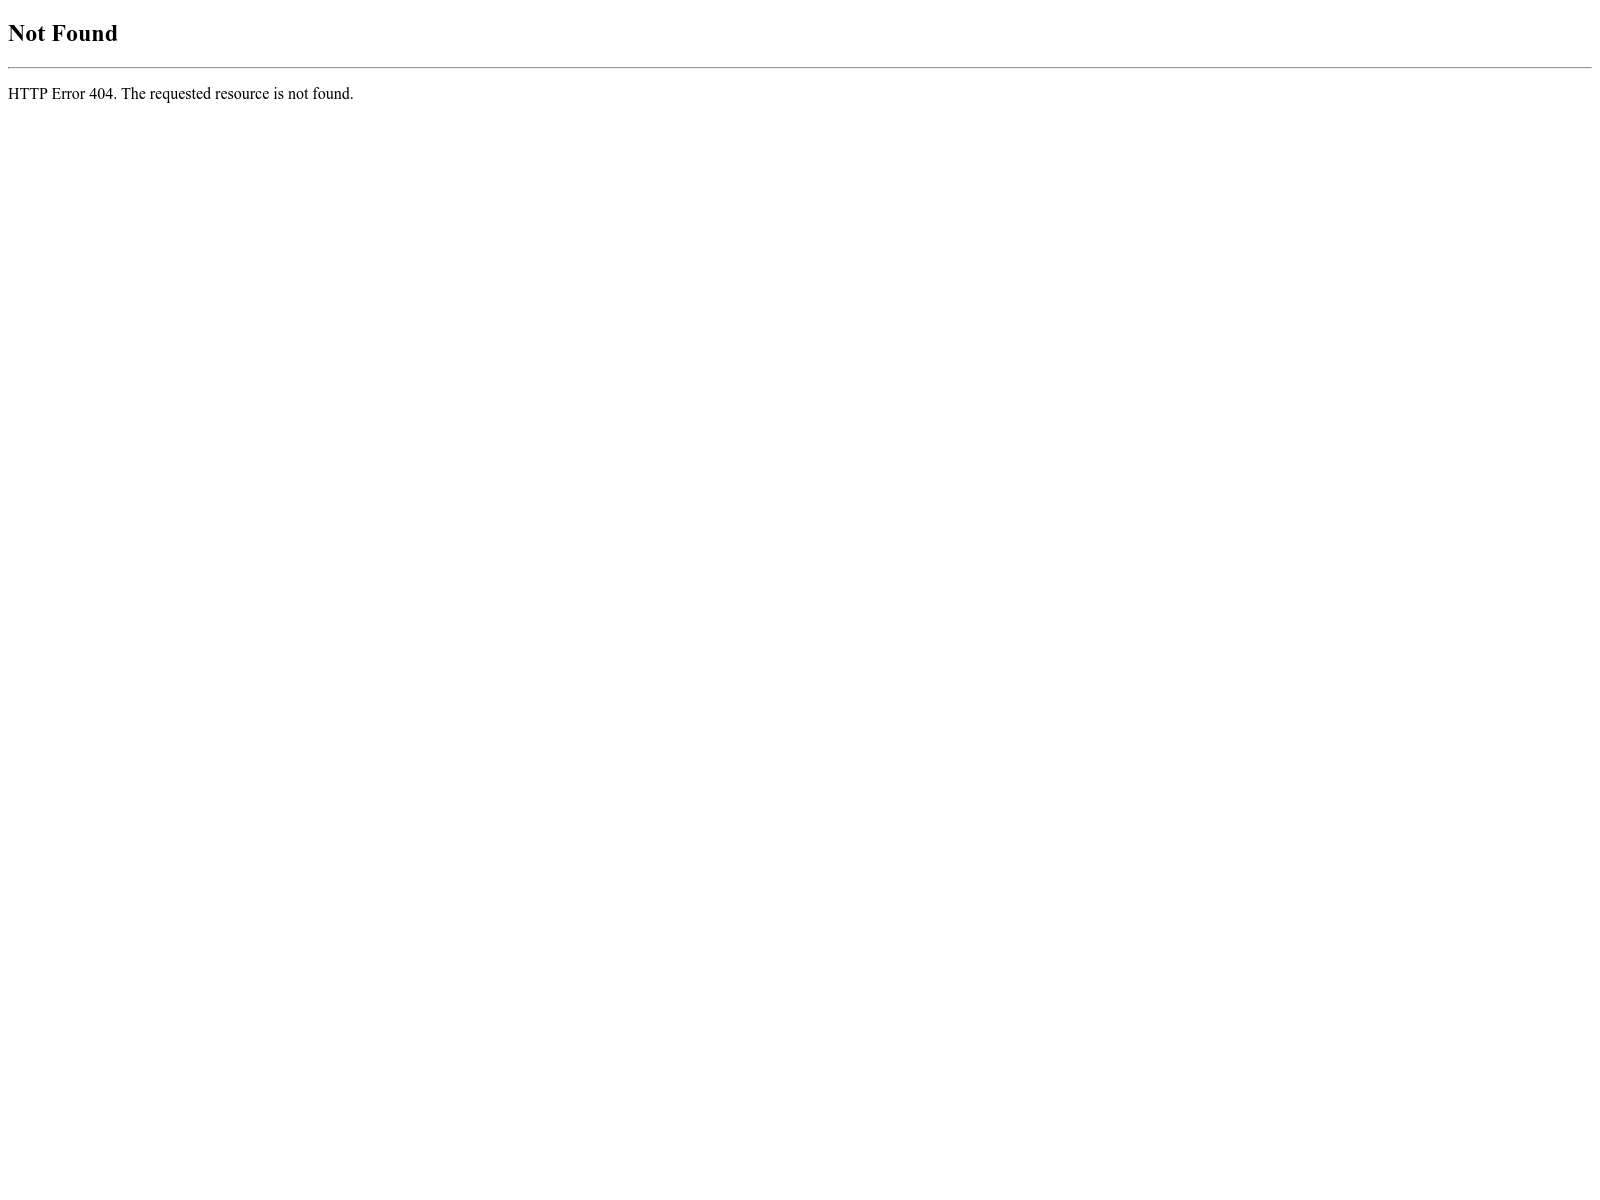



https://www.mikeylinehan.com/ for mikeylinehan.com at 2019-01-18T08:05:55.338Z


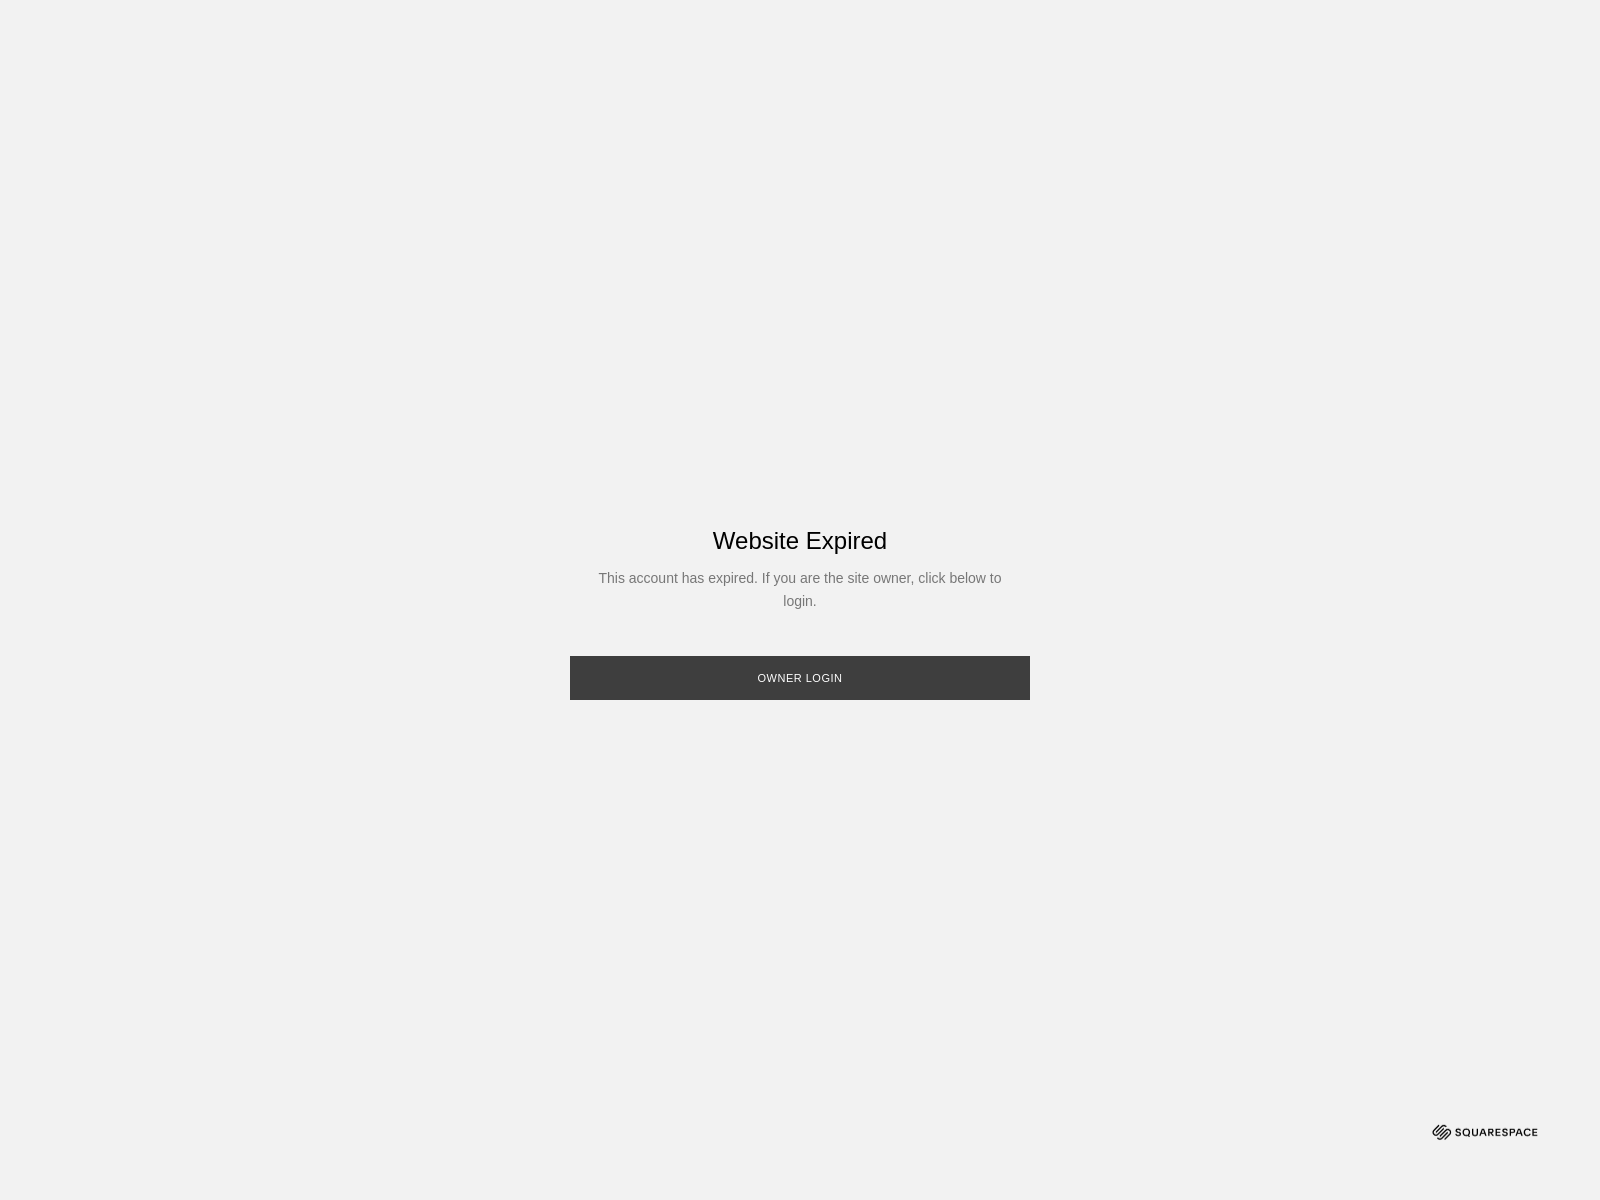



http://mikeylinehan.com/ for mikeylinehan.com at 2018-03-09T09:39:05.105Z


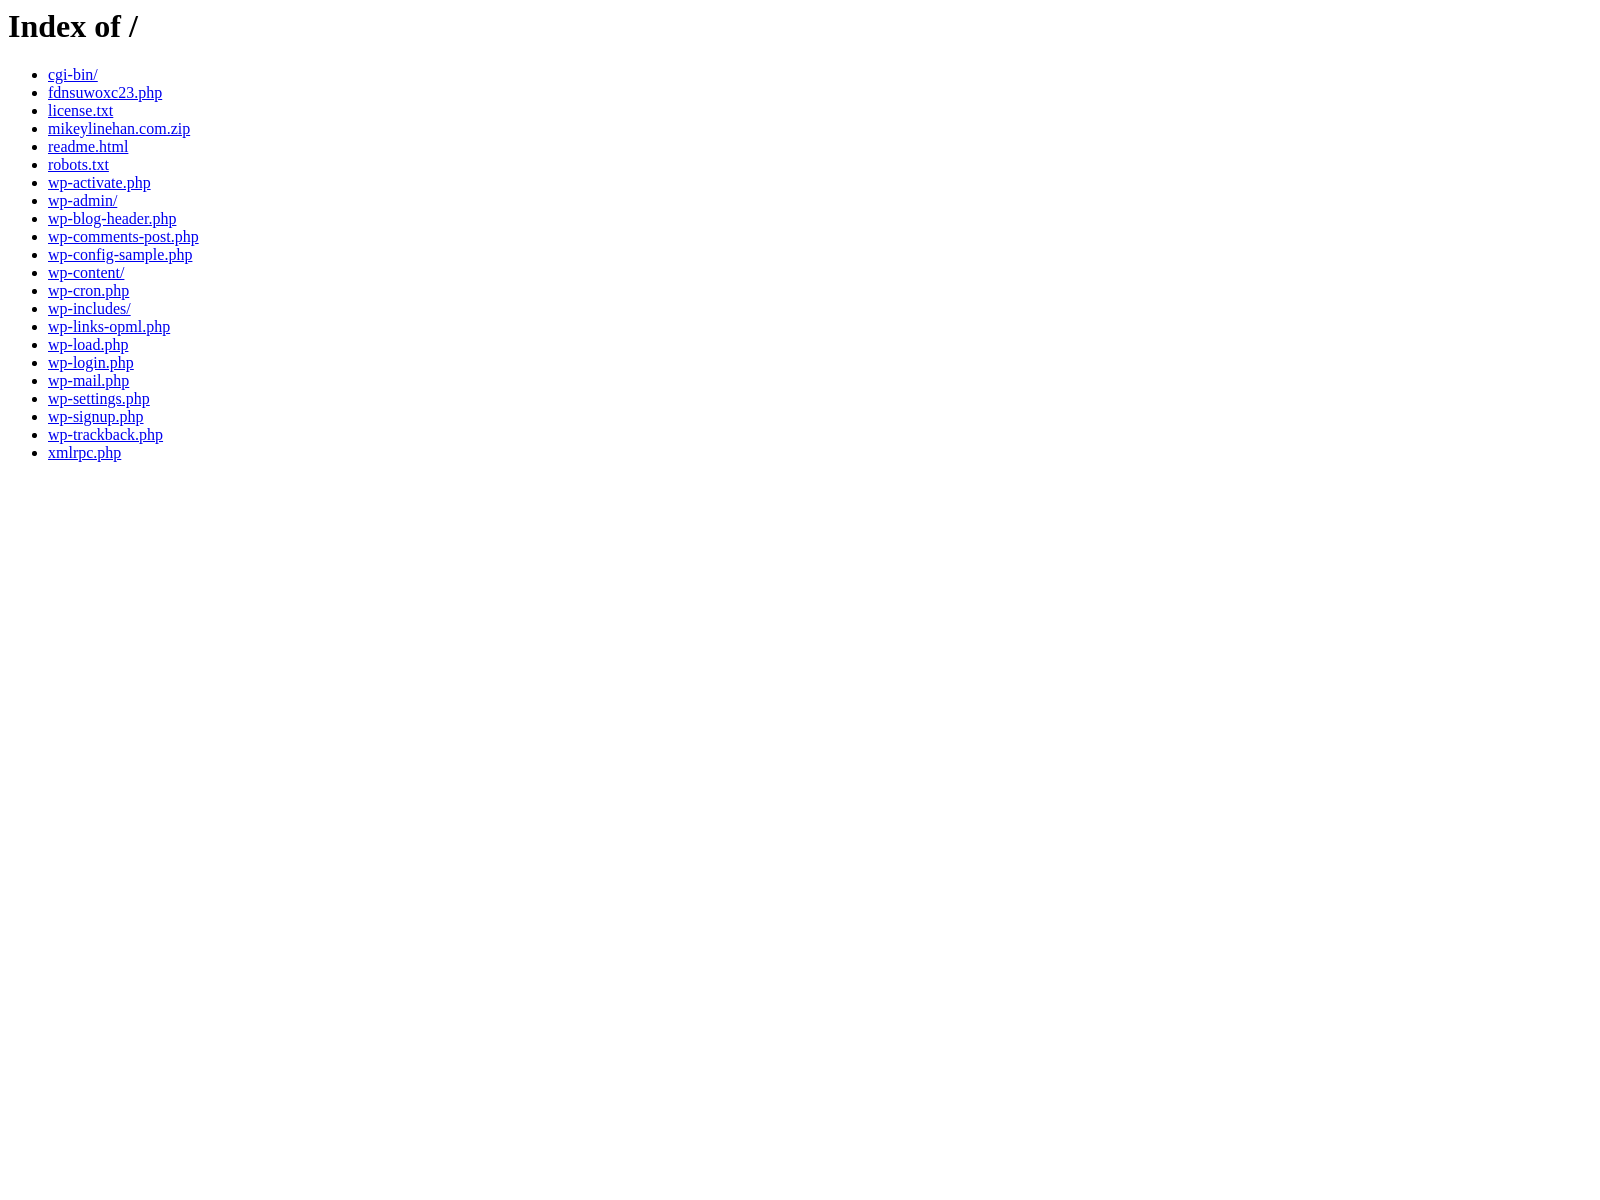



http://mikeylinehan.com/kjdfhg874 for mikeylinehan.com at 2018-03-09T09:37:29.736Z


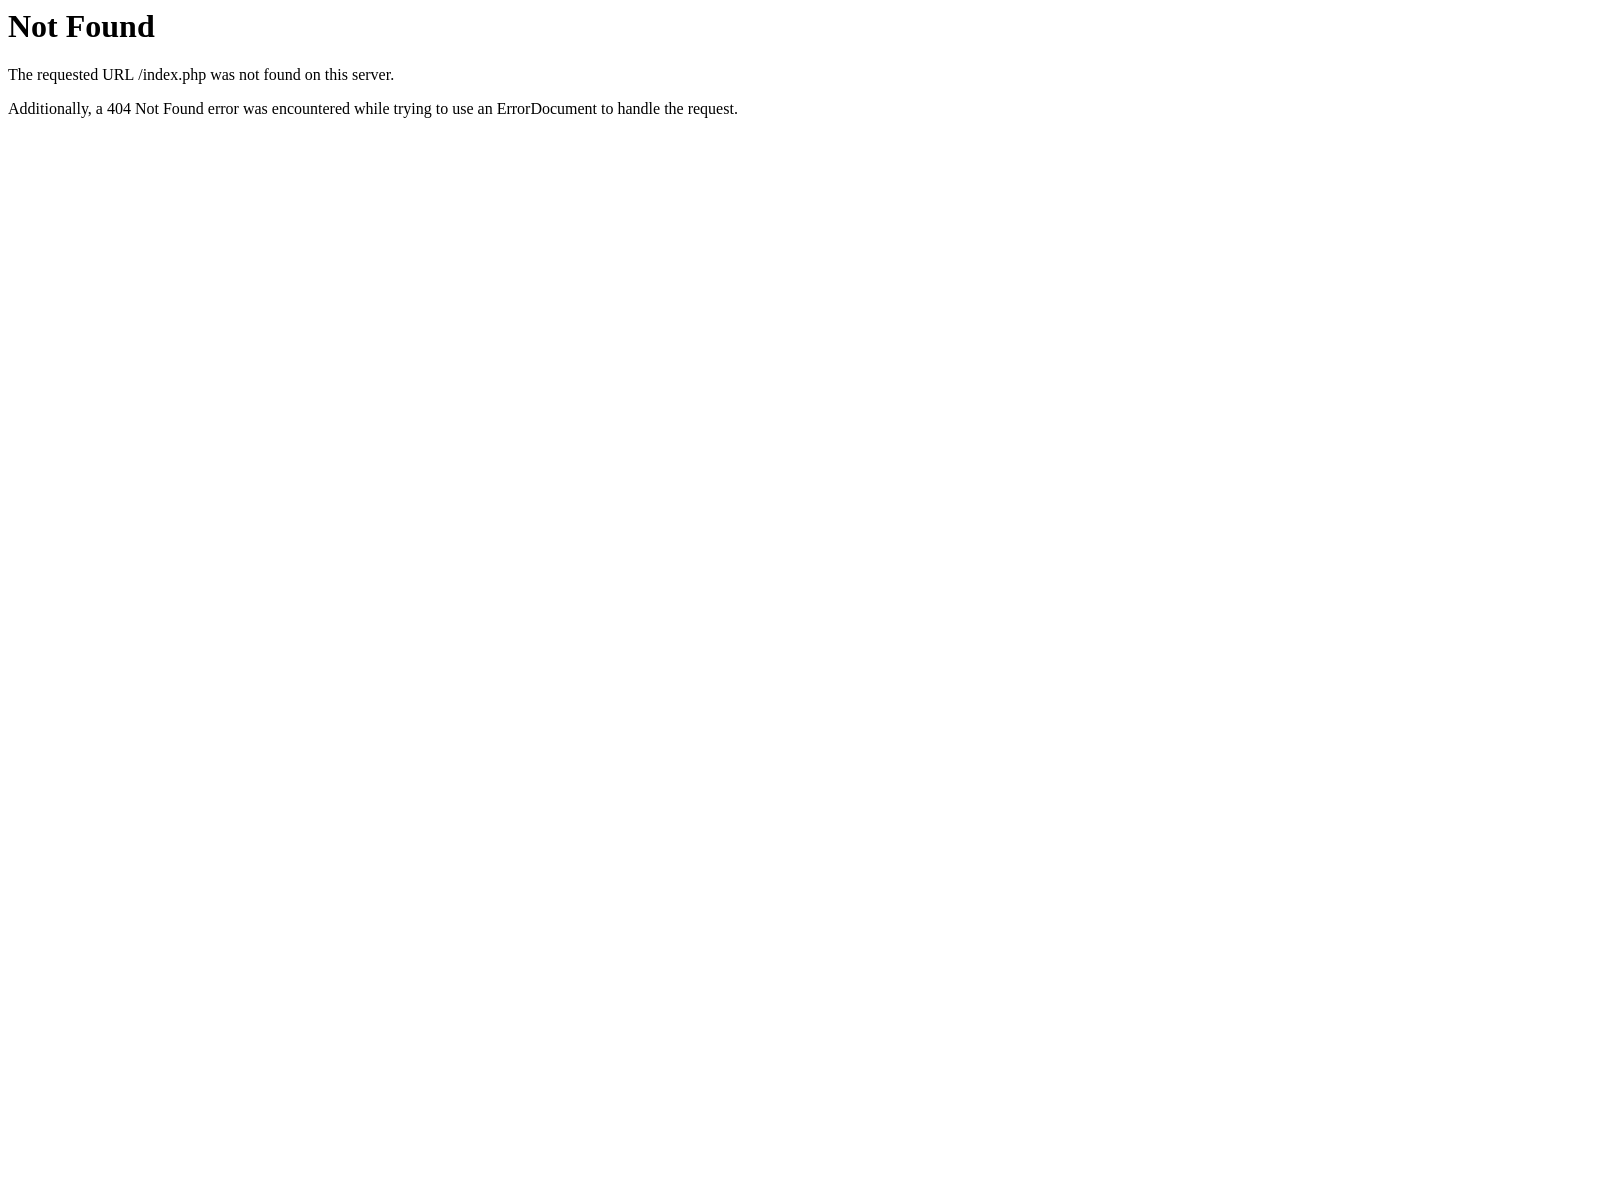



http://mikeylinehan.com/kjdfhg874 for mikeylinehan.com at 2018-01-14T05:06:53.045Z


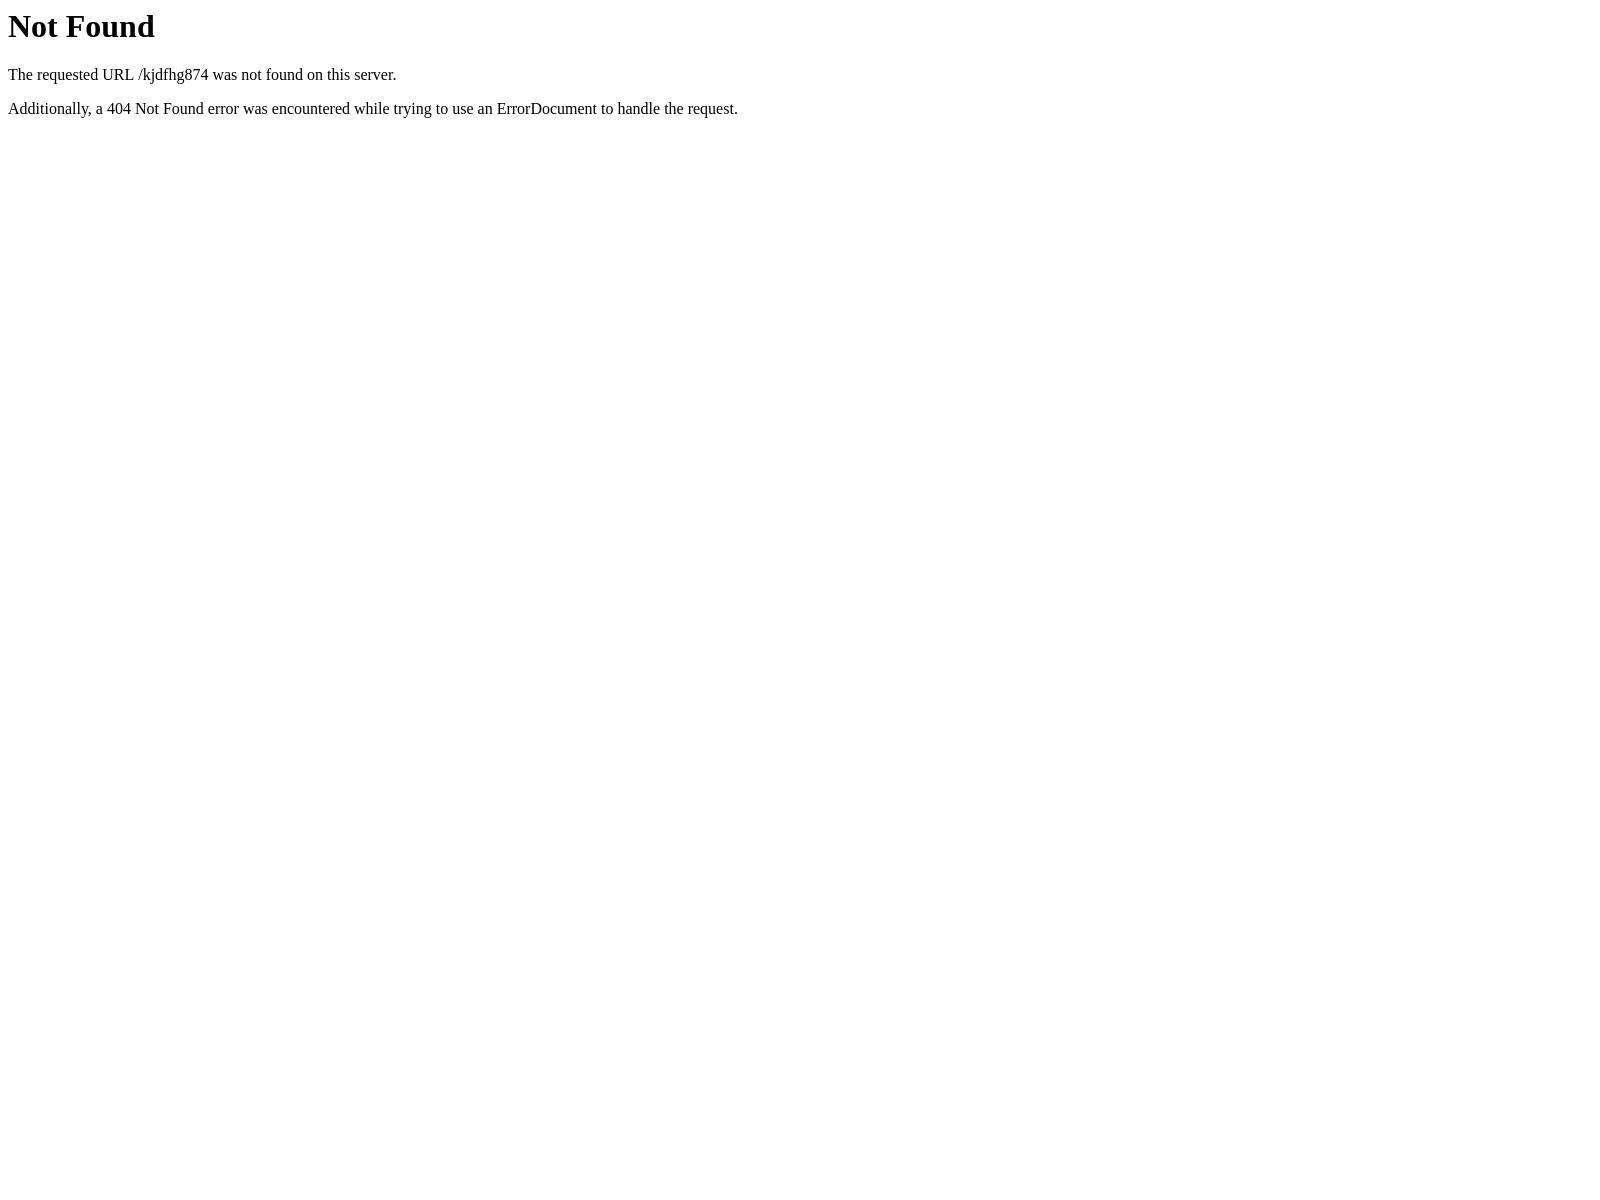

In [37]:
# Store the displayed results in a list. If you want to print them later you can just use this list
displayed = []
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "URLscan.io": 
            if "screenshot_name" in match:
                if match["screenshot"] not in displayed:
                    print("{} for {} at {}".format(match["screenshot_url"], domain, match.get("screenshot_time", "Unknown")))
                    display(Image(base64.b64decode(match["screenshot"]), width=240))
                    displayed.append(match["screenshot"])
                    print("\n")

## ER:10 Review and export final MISP event graph

Once the object relations have been added you can also display them on a graph, similar as we did in an earlier cell. Head over again to MISP and use the **Event graph** tab. This allows you to visually represent the objects, attributes and relations. Did you know you can also export these graphs to JSON, JPEG, PNG or the dot format? Under the **Export** button you can choose to export type. It's also possible to save the graph so that when you re-visit the event you can immediately have access to the lay of the objects you picked earlier. 

### Access the graph via the API

Additionally, it's also possible to access these "saved" event graphs via the **API**. If you have a graph, you can access them via `/event_graph/viewPicture/<mispevent_id>/<misp_eventgraph_id>`.

First, **save a graph** in the MISP interface under Event graph and then execute the next cell. Don't worry if you don't want to save the graph right away, the playbook will catch the error and continue without it.

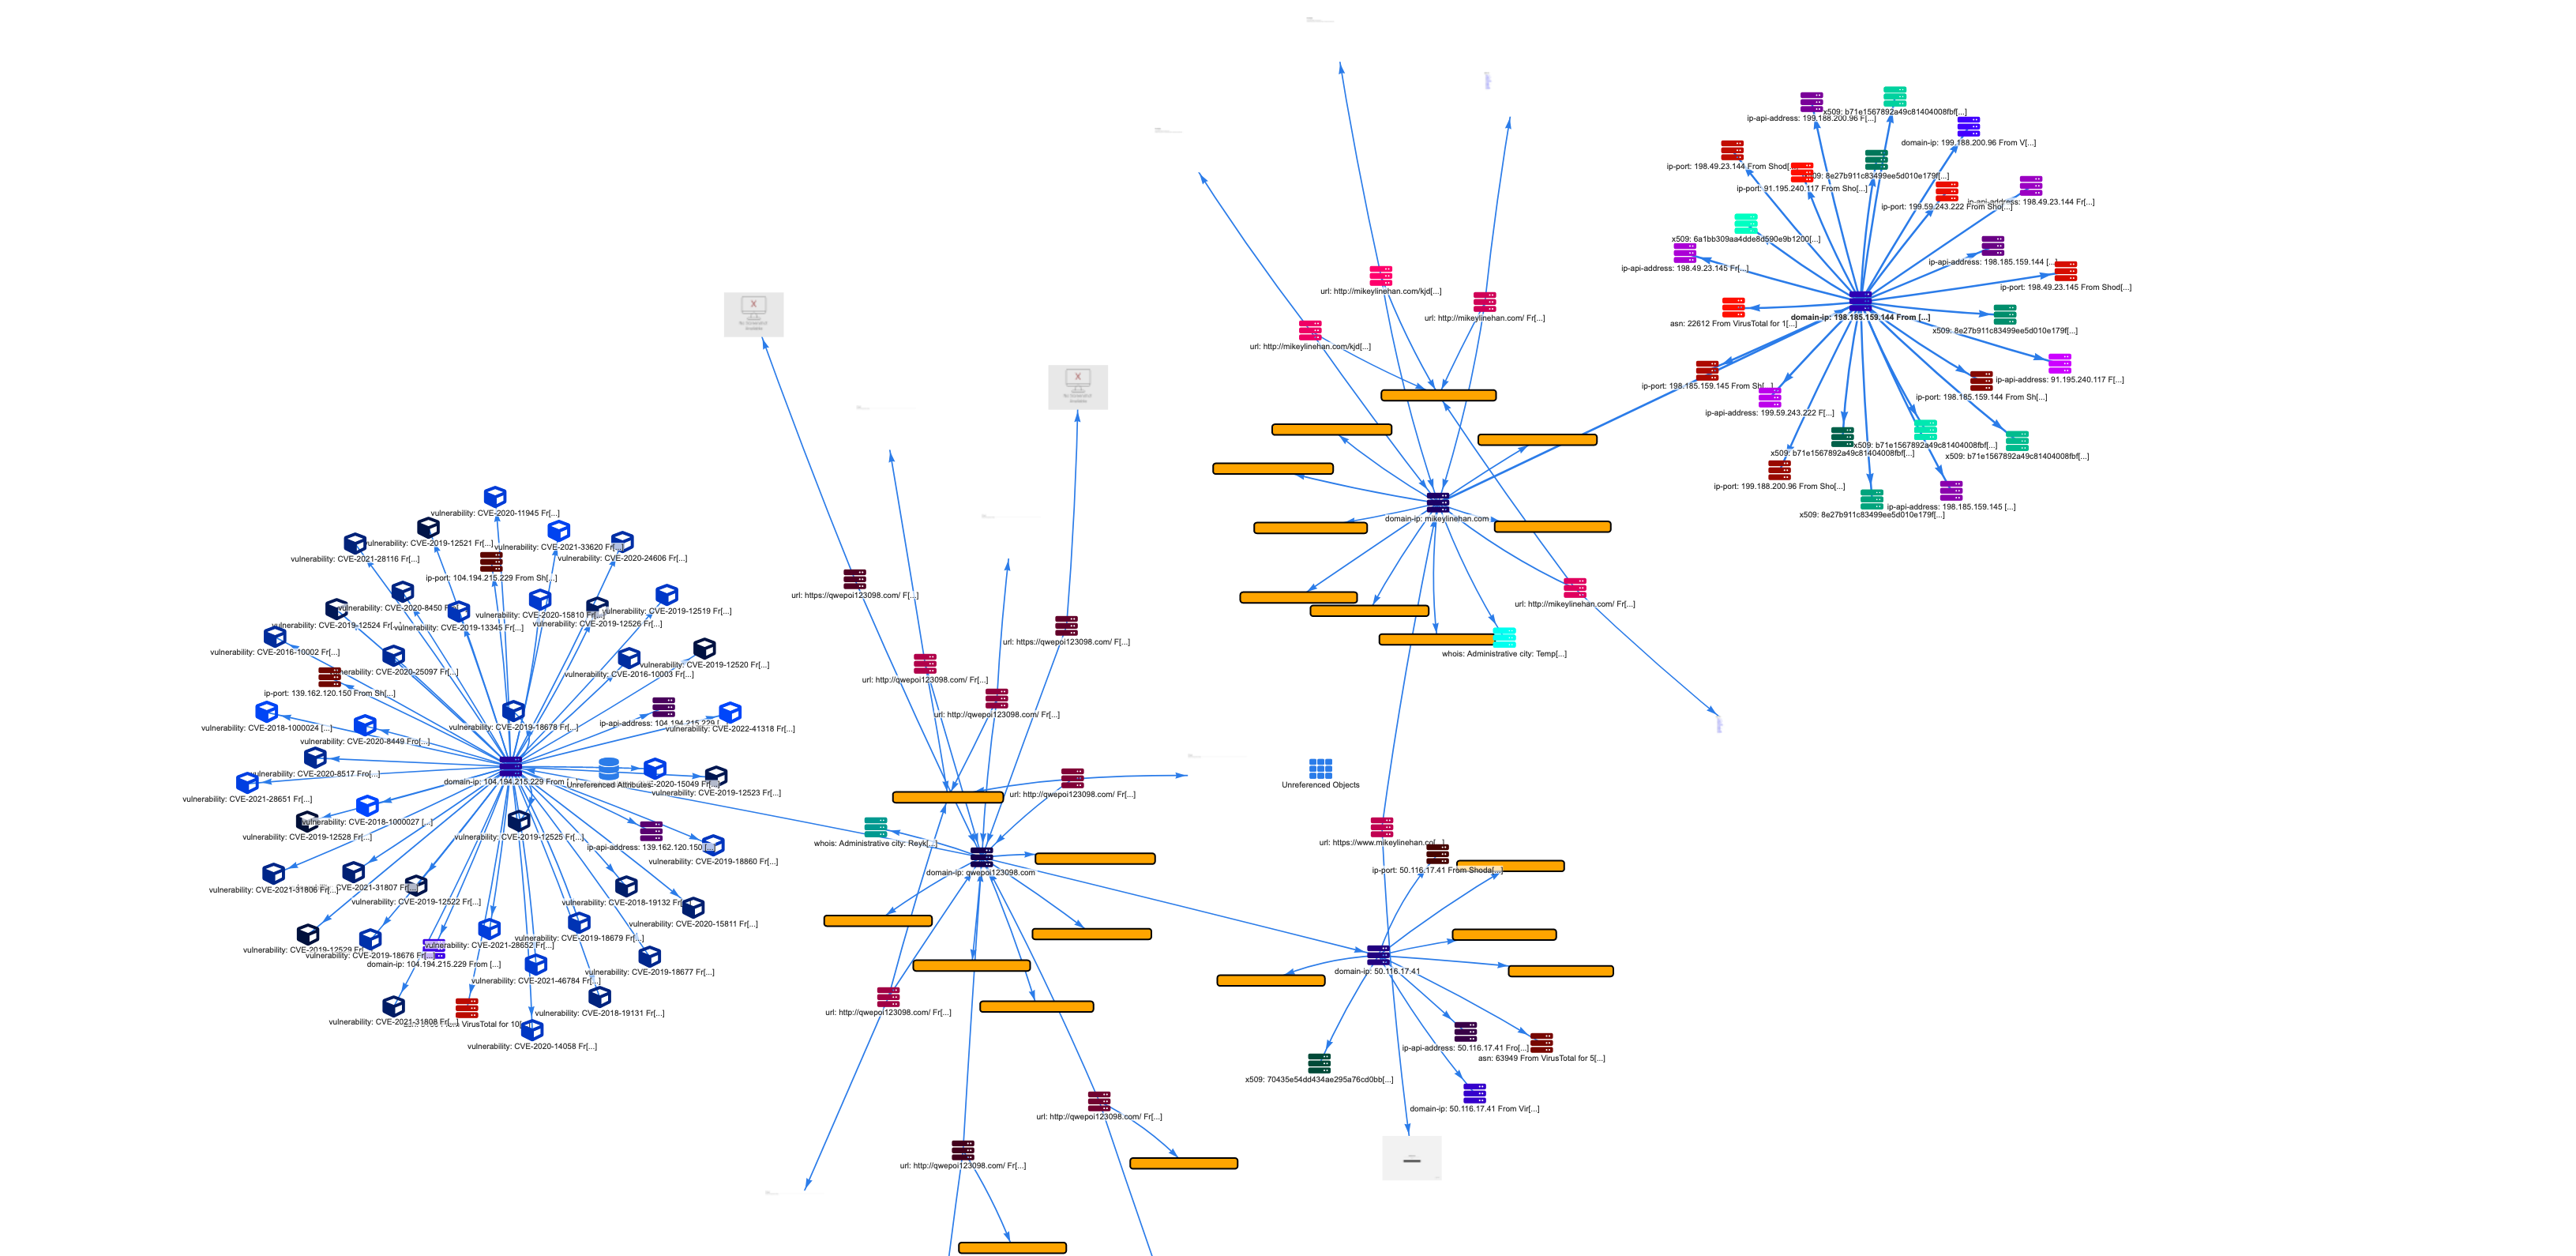

In [38]:
# Start with the first MISP Event graph
misp_eventgraph_id = 10

# We use the requests library and need to set the headers
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
event_graph = requests.get("{}/event_graph/viewPicture/{}/{}".format(misp_url, misp_event.id, misp_eventgraph_id), headers=misp_headers, verify=misp_verifycert)
if event_graph.status_code == 200:
    display(Image(event_graph.content, width=480))
else:
    print("Event \033[91mgraph not found\033[90m. Continue with the playbook.\n\n")

# Closure

In this **closure** or end step we create a **summary** of the actions that were performed by the playbook. The summary is printed in the playbook and can also be send to a chat channel. 

## EN:1 MISP indicators

The next section first **queries MISP for the indicators added to the MISP event** that is linked to the execution of this playbook.

The indicators are stored in the variable `indicator_table` (table format) and `indicator_raw_list` (in raw format) which is used in a later section to create the playbook summary.

In [39]:
# Get all the indicators for our event and store this is in a table. We can also use this for the summary.
indicator_search = misp.search("attributes", uuid=misp_event.uuid, to_ids=True, pythonify=True)
indicator_raw_list = []
indicator_table = PrettyTable()
if len(indicator_search) > 0:
    indicator_table.field_names = ["Type", "Category", "Indicator", "Comment"]
    indicator_table.align["Type"] = "l"
    indicator_table.align["Category"] = "l"
    indicator_table.align["Indicator"] = "l"
    indicator_table.align["Comment"] = "l"
    indicator_table.border = True
    for indicator in indicator_search:
        if indicator.value not in indicator_raw_list:
            indicator_table.add_row([indicator.type, indicator.category, indicator.value, indicator.comment])
            indicator_raw_list.append(indicator.value)
    print("Got \033[92m{}\033[90m indicator(s) from the event \033[92m{}\033[90m ({}).\n\n".format(len(indicator_raw_list), misp_event.info, misp_event.id))
else:
    print("\033[93mNo indicators found in the event \033[92m{}\033[90m ({})".format(misp_event.info, misp_event.id))


Got 12 indicator(s) from the event Domain reputation investigation for qwepoi123098.com mikeylinehan.com (2653).




### Raw list of MISP indicators

The indicators are now stored in `indicator_search` (as Python objects) and `indicator_raw_list` (in raw format, only the indicators). Execute the next cell to display them in a table format. The table is also included in the summary sent to Mattermost and TheHive.

In [40]:
if len(indicator_raw_list) > 0:
    print(indicator_table.get_string(sortby="Type"))
    print("\n\nIndicator list in raw format:")
    print("---------------------------------------------------")
    for el in indicator_raw_list:
        print("{}".format(el))
    print("---------------------------------------------------")

+--------+------------------+-----------------------------------+-----------------------------------------+
| Type   | Category         | Indicator                         | Comment                                 |
+--------+------------------+-----------------------------------+-----------------------------------------+
| domain | Network activity | mikeylinehan.com                  | Added by playbook                       |
| domain | Network activity | qwepoi123098.com                  | Added by playbook                       |
| ip-dst | Network activity | 104.194.215.229                   | From URLscan.io                         |
| ip-dst | Network activity | 198.185.159.144                   | From URLscan.io                         |
| ip-dst | Network activity | 199.188.200.96                    | From URLscan.io                         |
| ip-dst | Network activity | 50.116.17.41                      | From URLscan.io                         |
| md5    | Payload delivery 

## EN:2 Create the summary of the playbook

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables are later used when sending information to Mattermost or TheHive.

In [41]:
summary = "## MISP Playbook summary\nQuery domain reputation with MISP event: **{}** ({}/events/view/{}). ".format(misp_event.info, misp_url, misp_event.id)

summary_domains = ""
for domain in query_domain:
    summary_domains = "{}{} ".format(summary_domains, domain)
summary += "This concerned the investigation of domains **{}**\n\n".format(summary_domains)
intro = summary

summary += "### Indicators\n\n"
summary += "#### Indicators table\n\n"
if len(indicator_raw_list) > 0:
    indicator_table.set_style(MARKDOWN)
    summary += indicator_table.get_string(sortby="Type")
    summary += "\n\n\n" 
    summary += "#### Indicators in **raw format**\n\n"
    for indicator in indicator_raw_list:
        summary += "{}\n\n".format(indicator)
    summary += "\n" 
else:
    summary += "There are no indicators"
summary += "\n\n"

summary += "### Correlations\n\n"
summary += "#### MISP event matches\n\n"
table_mispevents.set_style(MARKDOWN)
summary += table_mispevents.get_string()
summary += "\n\n"

summary += "#### MISP feed matches\n\n"
table_mispfeeds.set_style(MARKDOWN)
summary += table_mispfeeds.get_string()
summary += "\n\n"

summary += "### Enrichment\n\n"
summary += "#### URLscan\n\n"
table_urlscan.set_style(MARKDOWN)
summary += table_urlscan.get_string()
summary += "\n\n"

summary_second = "## MISP Playbook summary\nQuery domain reputation with MISP event: **{}** ({}/events/view/{}) (continuation). ".format(misp_event.info, misp_url, misp_event.id)
# Some tables are optional, if previous cells are skipped
if table_dns:
    summary += "#### DNS\n\n"
    table_dns.set_style(MARKDOWN)
    summary += table_dns.get_string()
    summary += "\n\n"
    
if table_abuse:
    summary += "#### Abuse information\n\n"
    table_abuse.set_style(MARKDOWN)
    summary += table_abuse.get_string()
    summary += "\n\n"    
    
if table_customentries:
    summary += "#### Custom enrichment information\n\n"
    table_customentries.set_style(MARKDOWN)
    summary += table_customentries.get_string()
    summary += "\n\n" 
    
if table_virustotal:
    summary += "#### VirusTotal\n\n"
    table_virustotal.set_style(MARKDOWN)
    summary += table_virustotal.get_string()
    summary += "\n\n"

if table_shodan:
    summary += "#### Shodan\n\n"
    table_shodan.set_style(MARKDOWN)
    summary += table_shodan.get_string()
    summary += "\n\n"

if table_urlhaus:
    summary += "#### URLhaus\n\n"
    table_urlhaus.set_style(MARKDOWN)
    summary += table_urlhaus.get_string()
    summary += "\n\n"

summary += "### Screenshots via URLscan\n\n"
summary_urls = []
for domain in playbook_results:
    for match in playbook_results[domain]:
        if match["source"] == "URLscan.io": 
            if "screenshot_name" in match:
                summary_urls.append({"image_url": match["screenshot_urlscan"]})
                summary += "- {}\n".format(match["screenshot_urlscan"])
summary += "\n\n"

print("The \033[92msummary\033[90m of the playbook is available.\n")

The summary of the playbook is available.



#### Print the summary

In [69]:
display_markdown(summary, raw=True)

## MISP Playbook summary
Query domain reputation with MISP event: **Domain reputation investigation for qwepoi123098.com mikeylinehan.com** (https://misp.demo.cudeso.be//events/view/2653). This concerned the investigation of domains **qwepoi123098.com mikeylinehan.com **

### Indicators

#### Indicators table

| Type   | Category         | Indicator                         | Comment                                 |
|:-------|:-----------------|:----------------------------------|:----------------------------------------|
| domain | Network activity | mikeylinehan.com                  | Added by playbook                       |
| domain | Network activity | qwepoi123098.com                  | Added by playbook                       |
| ip-dst | Network activity | 104.194.215.229                   | From URLscan.io                         |
| ip-dst | Network activity | 198.185.159.144                   | From URLscan.io                         |
| ip-dst | Network activity | 199.188.200.96                    | From URLscan.io                         |
| ip-dst | Network activity | 50.116.17.41                      | From URLscan.io                         |
| md5    | Payload delivery | 44d88612fea8a8f36de82e1278abb02f  | Added as custom enrichment - EICAR hash |
| url    | Network activity | http://mikeylinehan.com/          | From URLscan.io                         |
| url    | Network activity | http://mikeylinehan.com/kjdfhg874 | From URLscan.io                         |
| url    | Network activity | http://qwepoi123098.com/          | From URLscan.io                         |
| url    | Network activity | https://qwepoi123098.com/         | From URLscan.io                         |
| url    | Network activity | https://www.mikeylinehan.com/     | From URLscan.io                         |


#### Indicators in **raw format**

qwepoi123098.com

mikeylinehan.com

http://qwepoi123098.com/

50.116.17.41

https://qwepoi123098.com/

104.194.215.229

https://www.mikeylinehan.com/

198.185.159.144

http://mikeylinehan.com/

199.188.200.96

http://mikeylinehan.com/kjdfhg874

44d88612fea8a8f36de82e1278abb02f




### Correlations

#### MISP event matches

| Source | Value            | Category         | Type     | Event                                              | Event ID |
|:------:|:-----------------|:-----------------|:---------|:---------------------------------------------------|:---------|
|  MISP  | qwepoi123098.com | Network activity | domain   | CrowdStrike Falcon Platform Detects and Prevents   | 2540     |
|        |                  |                  |          | Active Intrusion Campaign Targeting 3CXDesktopApp  |          |
|        |                  |                  |          | Customers                                          |          |
|  MISP  | mikeylinehan.com | Network activity | hostname | M2M -  GlobeImposter "..doc" 2018-01-12 : "Unpaid  | 2051     |
|        |                  |                  |          | invoice " - "1234567.7z"                           |          |

#### MISP feed matches

| Source | Value            | Feed             |                                          URL                                          |
|:------:|:-----------------|:-----------------|:-------------------------------------------------------------------------------------:|
| Feeds  | mikeylinehan.com | CIRCL OSINT Feed | https://misp.demo.cudeso.be/feeds/previewEvent/1/5a607314-de88-4309-ba06-c4a9950d210f |

### Enrichment

#### URLscan

|   Source   | Value            | Category         | Type         | Enriched                                           |
|:----------:|:-----------------|:-----------------|:-------------|:---------------------------------------------------|
| URLscan.io | qwepoi123098.com | Network activity | url          | http://qwepoi123098.com/                           |
| URLscan.io | qwepoi123098.com | Network activity | ip-dst       | 50.116.17.41                                       |
| URLscan.io | qwepoi123098.com |                  | screenshot   | screenshot-qwepoi123098.com-0ebce94f-7291-4067-99e |
|            |                  |                  |              | 1-049c29992008.png for http://qwepoi123098.com/    |
| URLscan.io | qwepoi123098.com | Other            | umbrellaRank | 468477                                             |
| URLscan.io | qwepoi123098.com | Network activity | url          | https://qwepoi123098.com/                          |
| URLscan.io | qwepoi123098.com |                  | screenshot   | screenshot-qwepoi123098.com-                       |
|            |                  |                  |              | bb24693a-59f8-4e77-a939-9eca17126484.png for       |
|            |                  |                  |              | https://qwepoi123098.com/                          |
| URLscan.io | qwepoi123098.com | Other            | umbrellaRank | 752465                                             |
| URLscan.io | qwepoi123098.com | Network activity | ip-dst       | 104.194.215.229                                    |
| URLscan.io | qwepoi123098.com |                  | screenshot   | screenshot-qwepoi123098.com-b3402713-fa1e-4e47-a16 |
|            |                  |                  |              | c-624c0450aa8a.png for http://qwepoi123098.com/    |
| URLscan.io | qwepoi123098.com | Other            | server       | Microsoft-HTTPAPI/2.0                              |
| URLscan.io | mikeylinehan.com | Network activity | url          | https://www.mikeylinehan.com/                      |
| URLscan.io | mikeylinehan.com | Network activity | ip-dst       | 198.185.159.144                                    |
| URLscan.io | mikeylinehan.com |                  | screenshot   | screenshot-mikeylinehan.com-                       |
|            |                  |                  |              | aabf1a98-03f6-497b-a5de-9b6a74f35854.png for       |
|            |                  |                  |              | https://www.mikeylinehan.com/                      |
| URLscan.io | mikeylinehan.com | Network activity | url          | http://mikeylinehan.com/                           |
| URLscan.io | mikeylinehan.com | Network activity | ip-dst       | 199.188.200.96                                     |
| URLscan.io | mikeylinehan.com |                  | screenshot   | screenshot-mikeylinehan.com-5078b872-1baa-41be-a2d |
|            |                  |                  |              | 4-55d097ebc0ef.png for http://mikeylinehan.com/    |
| URLscan.io | mikeylinehan.com | Other            | server       | Apache                                             |
| URLscan.io | mikeylinehan.com | Network activity | url          | http://mikeylinehan.com/kjdfhg874                  |
| URLscan.io | mikeylinehan.com |                  | screenshot   | screenshot-mikeylinehan.com-f2ec917b-e9be-4497-a4e |
|            |                  |                  |              | b-a55401dd1a2a.png for                             |
|            |                  |                  |              | http://mikeylinehan.com/kjdfhg874                  |
| URLscan.io | mikeylinehan.com |                  | screenshot   | screenshot-mikeylinehan.com-083df698-5833-403d-86c |
|            |                  |                  |              | 9-c831d88efd79.png for                             |
|            |                  |                  |              | http://mikeylinehan.com/kjdfhg874                  |

#### DNS

| Source | Value            | Category         | Type   | Enriched     |
|:------:|:-----------------|:-----------------|:-------|:-------------|
|  DNS   | mikeylinehan.com | Network activity | ip-dst | 50.116.17.41 |

#### Abuse information

|    Source    | Value            | Category    | Type                   | Enriched                  |
|:------------:|:-----------------|:------------|:-----------------------|:--------------------------|
| abuse_finder | qwepoi123098.com | Attribution | whois-registrant-name  | NameCheap, Inc.           |
| abuse_finder | qwepoi123098.com | Attribution | whois-registrant-email | abuse@namecheap.com       |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-name  | Akamai Technologies, Inc. |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-name  | Linode                    |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-email | abuse@akamai.com          |
| abuse_finder | 50.116.17.41     | Attribution | whois-registrant-email | abuse@linode.com          |

#### Custom enrichment information

| Source | Value            | Category         | Type | Enriched                         |
|:------:|:-----------------|:-----------------|:-----|:---------------------------------|
| Custom | qwepoi123098.com | Payload delivery | md5  | 44d88612fea8a8f36de82e1278abb02f |

#### VirusTotal

|   Source   | Value            | Category         | Type   | Enriched                                           |
|:----------:|:-----------------|:-----------------|:-------|:---------------------------------------------------|
| VirusTotal | qwepoi123098.com | Payload delivery | sha256 | 2b6282da522f1f51ee6e0ed5e37aa55a191d34ffbb3c287cb2 |
|            |                  |                  |        | 0d71ad2bf25b4b                                     |
| VirusTotal | qwepoi123098.com | Payload delivery | sha256 | ce7127c38e30e92a021ed2bd09287713c6a923db9ffdb43f12 |
|            |                  |                  |        | 6e8965d777fbf0                                     |
| VirusTotal | qwepoi123098.com | Other            | whois  | Administrative city: Reykjavik                     |
|            |                  |                  |        | Administrative country: Iceland                    |
|            |                  |                  |        | Administrative email:                              |
|            |                  |                  |        | 3ff625069fc77a81s@withheldforprivacy.com           |
|            |                  |                  |        | Administrative state: Capital Region               |
|            |                  |                  |        | Create date: 2022-11-17 00:00:00                   |
|            |                  |                  |        | Domain name: qwepoi123098.com                      |
|            |                  |                  |        | Domain registrar id: 1068                          |
|            |                  |                  |        | Domain registrar url: http://www.namecheap.com     |
|            |                  |                  |        | Expiry date: 2023-11-17 00:00:00                   |
|            |                  |                  |        | Name server 1: dns1.registrar-servers.com          |
|            |                  |                  |        | Name server 2: dns2.registrar-servers.com          |
|            |                  |                  |        | Query time: 2022-11-19 01:25:51                    |
|            |                  |                  |        | Registrant city: ddbf76e4e8cee320                  |
|            |                  |                  |        | Registrant company: 4b7a0912c26a13e2               |
|            |                  |                  |        | Registrant country: Iceland                        |
|            |                  |                  |        | Registrant email:                                  |
|            |                  |                  |        | 3ff625069fc77a81s@withheldforprivacy.com           |
|            |                  |                  |        | Registrant name: 37bfbc24cafea5d2                  |
|            |                  |                  |        | Registrant phone: fc40cd552aeaa6b8                 |
|            |                  |                  |        | Registrant state: 3e0204199d8ebf9c                 |
|            |                  |                  |        | Registrant zip: f206c9d9737ad45d                   |
|            |                  |                  |        | Technical city: Reykjavik                          |
|            |                  |                  |        | Technical country: Iceland                         |
|            |                  |                  |        | Technical email:                                   |
|            |                  |                  |        | 3ff625069fc77a81s@withheldforprivacy.com           |
|            |                  |                  |        | Technical state: Capital Region                    |
|            |                  |                  |        | Update date: 2022-11-17 00:00:00                   |
| VirusTotal | qwepoi123098.com | Network activity | ip-dst | 139.162.120.150                                    |
| VirusTotal | qwepoi123098.com | Network activity | ip-dst | 146.70.87.109                                      |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 51c93eda00d090aae0d3e211fb1679aa6456df7dc51a7cd45b |
|            |                  |                  |        | f4d3b990b531c7                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 69fb7b96d2da05f2aef88efc9e788ede343c9112ae164fe026 |
|            |                  |                  |        | e504449d56464e                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 86749d3e3233d7a75a618c98eac9f31f508aed4492849f65b9 |
|            |                  |                  |        | 07787b0bd1d047                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 75d6289e33dbf05543f8a850e40c7bb3e3f8b9e2872015f8a7 |
|            |                  |                  |        | b09906aabb7b5e                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 5596dc862bd9aea2981ebe1f8a638557d1383ccd9a47c94c96 |
|            |                  |                  |        | 10300325f94a0e                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 77795c8a3c5a8ff8129cb4db828828c53a590f93583fcfb0b1 |
|            |                  |                  |        | 112a4e670c97d4                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | c45ef4a35047e14d8eaf54cab44a432be18e93915ac26a2f12 |
|            |                  |                  |        | 94d260f220aea8                                     |
| VirusTotal | mikeylinehan.com | Payload delivery | sha256 | 103d93ab0996ed79df9184183fb63f3c37c2fbd0aa505174e2 |
|            |                  |                  |        | 9256ddf02208b5                                     |
| VirusTotal | mikeylinehan.com | Other            | whois  | Administrative city: Tempe                         |
|            |                  |                  |        | Administrative country: United States              |
|            |                  |                  |        | Administrative state: Arizona                      |
|            |                  |                  |        | Create date: 2022-12-07 00:00:00                   |
|            |                  |                  |        | Domain name: mikeylinehan.com                      |
|            |                  |                  |        | Domain registrar id: 146                           |
|            |                  |                  |        | Domain registrar url: https://www.godaddy.com      |
|            |                  |                  |        | Expiry date: 2023-12-07 00:00:00                   |
|            |                  |                  |        | Name server 1: ns2.bodis.com                       |
|            |                  |                  |        | Name server 2: ns3.bd-verify-gu7sqsxf6r.com        |
|            |                  |                  |        | Name server 3: ns1.bodis.com                       |
|            |                  |                  |        | Query time: 2022-12-09 01:17:50                    |
|            |                  |                  |        | Registrant city: a7319ae5e6c95df5                  |
|            |                  |                  |        | Registrant company: 7f270b624abce87e               |
|            |                  |                  |        | Registrant country: United States                  |
|            |                  |                  |        | Registrant email: 501c8f3031df1b66s@               |
|            |                  |                  |        | Registrant fax: 73632f3e7db2cc41                   |
|            |                  |                  |        | Registrant name: 80315b2e6ac1a801                  |
|            |                  |                  |        | Registrant phone: b03d5abc696b79f6                 |
|            |                  |                  |        | Registrant state: 30bdd2917a604c83                 |
|            |                  |                  |        | Registrant zip: 052e5bd148f904f9                   |
|            |                  |                  |        | Technical city: Tempe                              |
|            |                  |                  |        | Technical country: United States                   |
|            |                  |                  |        | Technical state: Arizona                           |
|            |                  |                  |        | Update date: 2022-12-07 00:00:00                   |
| VirusTotal | mikeylinehan.com | Network activity | ip-dst | 198.185.159.145                                    |
| VirusTotal | mikeylinehan.com | Network activity | ip-dst | 198.49.23.144                                      |
| VirusTotal | mikeylinehan.com | Network activity | ip-dst | 198.49.23.145                                      |
| VirusTotal | mikeylinehan.com | Network activity | ip-dst | 199.59.243.222                                     |
| VirusTotal | mikeylinehan.com | Network activity | ip-dst | 91.195.240.117                                     |
| VirusTotal | 50.116.17.41     | Network activity | AS     | 63949                                              |
| VirusTotal | 50.116.17.41     | Other            | text   | US                                                 |
| VirusTotal | 50.116.17.41     | Network activity | ip-dst | 50.116.17.41                                       |
| VirusTotal | 104.194.215.229  | Network activity | AS     | 8100                                               |
| VirusTotal | 104.194.215.229  | Other            | text   | US                                                 |
| VirusTotal | 104.194.215.229  | Network activity | ip-dst | 104.194.215.229                                    |
| VirusTotal | 199.188.200.96   | Network activity | AS     | 22612                                              |
| VirusTotal | 199.188.200.96   | Other            | text   | US                                                 |
| VirusTotal | 199.188.200.96   | Network activity | ip-dst | 199.188.200.96                                     |

#### Shodan

| Source | Value           | Category          | Type                    | Enriched                                           |
|:------:|:----------------|:------------------|:------------------------|:---------------------------------------------------|
| Shodan | 50.116.17.41    | Network activity  | AS                      | AS63949                                            |
| Shodan | 50.116.17.41    | Network activity  | domain                  | linode.com                                         |
| Shodan | 50.116.17.41    | Network activity  | hostname                | li601-41.members.linode.com                        |
| Shodan | 50.116.17.41    | Network activity  | x509-fingerprint-sha256 | 70435e54dd434ae295a76cd0bb98375c7162e66c69a7b92bf7 |
|        |                 |                   |                         | 9cfe29bff32ad5                                     |
| Shodan | 50.116.17.41    | Network activity  | x509-fingerprint-sha1   | 306654bab3f48527a550b23c2b7a2d9431fc2ff8           |
| Shodan | 104.194.215.229 | Network activity  | AS                      | AS8100                                             |
| Shodan | 104.194.215.229 | Network activity  | domain                  | www3iwebonline.com                                 |
| Shodan | 104.194.215.229 | Network activity  | hostname                | ntx5.www3iwebonline.com                            |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12528                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12529                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12520                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12521                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12522                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12523                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12524                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12525                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12526                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-31808                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-19132                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-15811                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-31807                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-28116                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-19131                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-8450                                      |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-31806                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-18677                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-8517                                      |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-25097                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2016-10002                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2016-10003                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-24606                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-18676                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-18678                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-18679                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-13345                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-18860                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-14058                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2019-12519                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-15810                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-46784                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-11945                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-28652                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-28651                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-15049                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2020-8449                                      |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2021-33620                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-1000024                                   |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2022-41318                                     |
| Shodan | 104.194.215.229 | External analysis | vulnerability           | CVE-2018-1000027                                   |
| Shodan | 199.188.200.96  | Network activity  | AS                      | AS22612                                            |
| Shodan | 199.188.200.96  | Network activity  | domain                  | web-hosting.com                                    |
| Shodan | 199.188.200.96  | Network activity  | hostname                | server247-4.web-hosting.com                        |
| Shodan | 199.188.200.96  | Network activity  | x509-fingerprint-sha256 | 8e27b911c83499ee5d010e179fee08846da6f444e6f9a84bed |
|        |                 |                   |                         | 504f20ee423120                                     |
| Shodan | 199.188.200.96  | Network activity  | x509-fingerprint-sha1   | 02db451c9a07018198d21b3372f90ae8094db291           |
| Shodan | 139.162.120.150 | Network activity  | AS                      | AS63949                                            |
| Shodan | 139.162.120.150 | Network activity  | ip-src                  | 139.162.120.150                                    |
| Shodan | 139.162.120.150 | Network activity  | domain                  | linode.com                                         |
| Shodan | 139.162.120.150 | Network activity  | hostname                | li1604-150.members.linode.com                      |
| Shodan | 198.185.159.144 | Network activity  | AS                      | AS53831                                            |
| Shodan | 198.185.159.144 | Network activity  | ip-src                  | 198.185.159.144                                    |
| Shodan | 198.185.159.144 | Network activity  | domain                  | sqsp.net                                           |
| Shodan | 198.185.159.144 | Network activity  | domain                  | squarespace.com                                    |
| Shodan | 198.185.159.144 | Network activity  | domain                  | sqspcdn.com                                        |
| Shodan | 198.185.159.144 | Network activity  | domain                  | squarespace-mail.com                               |
| Shodan | 198.185.159.144 | Network activity  | domain                  | campaign-preferences.com                           |
| Shodan | 198.185.159.144 | Network activity  | hostname                | static1.1.sqspcdn.com                              |
| Shodan | 198.185.159.144 | Network activity  | hostname                | engage.squarespace-mail.com                        |
| Shodan | 198.185.159.144 | Network activity  | hostname                | static2.1.sqspcdn.com                              |
| Shodan | 198.185.159.144 | Network activity  | hostname                | cdn1.1.sqspcdn.com                                 |
| Shodan | 198.185.159.144 | Network activity  | hostname                | static1.2.sqspcdn.com                              |
| Shodan | 198.185.159.144 | Network activity  | x509-fingerprint-sha256 | b71e1567892a49c81404008fbfe4bab7f7c23428d3c2bdb236 |
|        |                 |                   |                         | 7541bd7d93b5cf                                     |
| Shodan | 198.185.159.144 | Network activity  | x509-fingerprint-sha1   | e0acde08badb08ae9930936e26bc713100a1d57e           |
| Shodan | 198.185.159.145 | Network activity  | AS                      | AS53831                                            |
| Shodan | 198.185.159.145 | Network activity  | ip-src                  | 198.185.159.145                                    |
| Shodan | 198.185.159.145 | Network activity  | domain                  | sqsp.net                                           |
| Shodan | 198.185.159.145 | Network activity  | domain                  | squarespace.com                                    |
| Shodan | 198.185.159.145 | Network activity  | domain                  | sqspcdn.com                                        |
| Shodan | 198.185.159.145 | Network activity  | domain                  | squarespace-mail.com                               |
| Shodan | 198.185.159.145 | Network activity  | domain                  | campaign-preferences.com                           |
| Shodan | 198.185.159.145 | Network activity  | hostname                | static1.1.sqspcdn.com                              |
| Shodan | 198.185.159.145 | Network activity  | hostname                | engage.squarespace-mail.com                        |
| Shodan | 198.185.159.145 | Network activity  | hostname                | static2.1.sqspcdn.com                              |
| Shodan | 198.185.159.145 | Network activity  | hostname                | cdn1.1.sqspcdn.com                                 |
| Shodan | 198.185.159.145 | Network activity  | hostname                | static1.2.sqspcdn.com                              |
| Shodan | 198.185.159.145 | Network activity  | x509-fingerprint-sha256 | b71e1567892a49c81404008fbfe4bab7f7c23428d3c2bdb236 |
|        |                 |                   |                         | 7541bd7d93b5cf                                     |
| Shodan | 198.185.159.145 | Network activity  | x509-fingerprint-sha1   | e0acde08badb08ae9930936e26bc713100a1d57e           |
| Shodan | 198.49.23.144   | Network activity  | AS                      | AS53831                                            |
| Shodan | 198.49.23.144   | Network activity  | ip-src                  | 198.49.23.144                                      |
| Shodan | 198.49.23.144   | Network activity  | domain                  | sqsp.net                                           |
| Shodan | 198.49.23.144   | Network activity  | domain                  | squarespace.com                                    |
| Shodan | 198.49.23.144   | Network activity  | domain                  | sqspcdn.com                                        |
| Shodan | 198.49.23.144   | Network activity  | domain                  | squarespace-mail.com                               |
| Shodan | 198.49.23.144   | Network activity  | domain                  | campaign-preferences.com                           |
| Shodan | 198.49.23.144   | Network activity  | hostname                | static1.1.sqspcdn.com                              |
| Shodan | 198.49.23.144   | Network activity  | hostname                | engage.squarespace-mail.com                        |
| Shodan | 198.49.23.144   | Network activity  | hostname                | static2.1.sqspcdn.com                              |
| Shodan | 198.49.23.144   | Network activity  | hostname                | cdn1.1.sqspcdn.com                                 |
| Shodan | 198.49.23.144   | Network activity  | hostname                | static1.2.sqspcdn.com                              |
| Shodan | 198.49.23.144   | Network activity  | x509-fingerprint-sha256 | b71e1567892a49c81404008fbfe4bab7f7c23428d3c2bdb236 |
|        |                 |                   |                         | 7541bd7d93b5cf                                     |
| Shodan | 198.49.23.144   | Network activity  | x509-fingerprint-sha1   | e0acde08badb08ae9930936e26bc713100a1d57e           |
| Shodan | 198.49.23.145   | Network activity  | AS                      | AS53831                                            |
| Shodan | 198.49.23.145   | Network activity  | ip-src                  | 198.49.23.145                                      |
| Shodan | 198.49.23.145   | Network activity  | domain                  | sqsp.net                                           |
| Shodan | 198.49.23.145   | Network activity  | domain                  | squarespace.com                                    |
| Shodan | 198.49.23.145   | Network activity  | domain                  | sqspcdn.com                                        |
| Shodan | 198.49.23.145   | Network activity  | domain                  | squarespace-mail.com                               |
| Shodan | 198.49.23.145   | Network activity  | domain                  | campaign-preferences.com                           |
| Shodan | 198.49.23.145   | Network activity  | hostname                | static1.1.sqspcdn.com                              |
| Shodan | 198.49.23.145   | Network activity  | hostname                | engage.squarespace-mail.com                        |
| Shodan | 198.49.23.145   | Network activity  | hostname                | static2.1.sqspcdn.com                              |
| Shodan | 198.49.23.145   | Network activity  | hostname                | cdn1.1.sqspcdn.com                                 |
| Shodan | 198.49.23.145   | Network activity  | hostname                | static1.2.sqspcdn.com                              |
| Shodan | 198.49.23.145   | Network activity  | x509-fingerprint-sha256 | b71e1567892a49c81404008fbfe4bab7f7c23428d3c2bdb236 |
|        |                 |                   |                         | 7541bd7d93b5cf                                     |
| Shodan | 198.49.23.145   | Network activity  | x509-fingerprint-sha1   | e0acde08badb08ae9930936e26bc713100a1d57e           |
| Shodan | 199.59.243.222  | Network activity  | AS                      | AS16509                                            |
| Shodan | 199.59.243.222  | Network activity  | ip-src                  | 199.59.243.222                                     |
| Shodan | 199.59.243.222  | Network activity  | x509-fingerprint-sha256 | 6a1bb309aa4dde8d590e9b1200dd9981dab62536ed0d8421e9 |
|        |                 |                   |                         | 0c6a67a8b9bc62                                     |
| Shodan | 199.59.243.222  | Network activity  | x509-fingerprint-sha1   | 5cc899fcdffdb78fdc35e29f22ce47caeb574c19           |
| Shodan | 91.195.240.117  | Network activity  | AS                      | AS47846                                            |
| Shodan | 91.195.240.117  | Network activity  | ip-src                  | 91.195.240.117                                     |

#### URLhaus

| Source | Value | Category | Type | Enriched |
|:------:|:------|:---------|:-----|:---------|

### Screenshots via URLscan

- https://urlscan.io/screenshots/0ebce94f-7291-4067-99e1-049c29992008.png
- https://urlscan.io/screenshots/bb24693a-59f8-4e77-a939-9eca17126484.png
- https://urlscan.io/screenshots/b3402713-fa1e-4e47-a16c-624c0450aa8a.png
- https://urlscan.io/screenshots/aabf1a98-03f6-497b-a5de-9b6a74f35854.png
- https://urlscan.io/screenshots/5078b872-1baa-41be-a2d4-55d097ebc0ef.png
- https://urlscan.io/screenshots/f2ec917b-e9be-4497-a4eb-a55401dd1a2a.png
- https://urlscan.io/screenshots/083df698-5833-403d-86c9-c831d88efd79.png




## EN:3 Send a summary to Mattermost

Now you can send the summary to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [59]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [62]:
# Set a bit below maximum size for message length https://docs.mattermost.com/upgrade/important-upgrade-notes.html
mattermost_max_length = 16300

message = False
lines = textwrap.wrap(summary, mattermost_max_length,  fix_sentence_endings=True, replace_whitespace=False)
line_count = 0
for line in lines:
    if send_to_mattermost_option == "via a chat message":
        message = {"username": mattermost_playbook_user, "text": line}
    elif send_to_mattermost_option == "via a chat message with card":
        message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": line}}
    if message:
        r = requests.post(mattermost_hook, data=json.dumps(message))
        r.raise_for_status()
    if message and r.status_code == 200:
        print("Summary {} of {} is \033[92msent to Mattermost\033[90m.".format(line_count, len(lines) - 1))
        line_count += 1
    else:
        print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

if len(summary_urls) > 0:        
    message = {"username": mattermost_playbook_user, "text": "Screenshots", "attachments": summary_urls}
    if message:
        r = requests.post(mattermost_hook, data=json.dumps(message))
        r.raise_for_status()
    if message and r.status_code == 200:
        print("Screenshots are \033[92msent to Mattermost\033[90m.\n")
    else:
        print("\033[91mFailed to sent screenshots \033[90m to Mattermost.\n")    

Summary 0 of 2 is sent to Mattermost.
Summary 1 of 2 is sent to Mattermost.
Summary 2 of 2 is sent to Mattermost.
Screenshots are sent to Mattermost.



![helpers/playbook-query_domain_reputation_mattermost.png](helpers/playbook-query_domain_reputation_mattermost.png)

## EN:4 Send an alert to TheHive

Next to informing your colleagues via Mattermost you can also send an **alert** to TheHive. The alert contains the summary, and a list of indicators as 'observables'.

You can change the alert title with `thehive_alert_title` and provide a reference type with `thehive_alert_reference`. Note that this reference needs to be **unique** in TheHive. If you want to create multiple alerts for the same MISP event then add some random value at the end.

In [65]:
# The title of the TheHive alert
thehive_alert_title = "MISP Playbook Summary"

# A unique reference for the TheHive (we include the MISP event UUID)
thehive_alert_reference = "MISP event - {} - {}".format(misp_event.info, misp_event.uuid)

# Alert type in TheHive
thehive_alert_type = "MISP Playbook alert"

# TLP:Amber for TheHive
thehive_tlp = 2

# PAP:GREEN for TheHive
thehive_pap = 1

In [66]:
# Code block to send an alert to TheHive
# We use the Python requests library
thehive_headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {thehive_key}'}
thehive_url_create = "{}/api/v1/alert".format(thehive_url)

thehive_observables = []
for indicator in indicator_search:
    dataType = False
    if indicator.type == "ip-src" or indicator.type == "ip-dst":
        dataType = "ip"
    elif indicator.type == "url":
        dataType = "url"
    elif indicator.type == "hostname":
        dataType = "hostname"        
    elif indicator.type == "email-dst" or indicator.type == "email-src":        
        dataType = "mail"
    if dataType:
        thehive_observables.append({"dataType": dataType, "data": indicator.value, "pap": thehive_pap, "tlp": thehive_tlp})
thehive_alert = {"title": thehive_alert_title, 
                 "description": intro,
                 "summary": summary[0:1048576],
                 "type": thehive_alert_type, 
                 "source": "playbook", 
                 "sourceRef": thehive_alert_reference, 
                 "tlp": thehive_tlp, "pap": thehive_pap,
                 "observables": thehive_observables}

result = requests.post(thehive_url_create, headers=thehive_headers, data=json.dumps(thehive_alert))
if result.json()['status'] == 'New':
    thehive_alert_id = result.json()['_id']
    print('The TheHive \033[92malert {} is added'.format(thehive_alert_id))
else:
    print('\033[91mFailed\033[90m to add TheHive alert')
    print(result.text)

The TheHive alert ~41029736 is added


![helpers/playbook-query_domain_reputation_thehive.png](helpers/playbook-query_domain_reputation_thehive.png)

## EN:5 Publish MISP event 

As a final step, you can choose the **publish** the MISP event. 

### Remaining workflow todo's

This step will remove the **workflow** states incomplete, add a workflow state complete and then publish the event.

The playbook will also remove the workflow **todo** tags. If you have not addressed them yet then now might be a good time to do that before publishing the event.

### Publish

Publishing MISP events makes the event available to your users and, depending on the synchronisation and distribution rules, will also sync it with other connected MISP servers. Publishing an event also typically makes the indicators available for your security controls to import them in their ruleset.

In [67]:
try:
    misp.untag(misp_event.uuid, "workflow:state=\"incomplete\"")
    misp.untag(misp_event.uuid, "workflow:todo=\"review-for-privacy\"")    
    misp.untag(misp_event.uuid, "workflow:todo=\"review-for-false-positive\"")        
    misp.tag(misp_event.uuid, "workflow:state=\"complete\"", local=True)
    print("Removed workflow todo tags and removed incomplete tag. Added complete tag.")
    misp.publish(misp_event.uuid)
    print("Event {} ({} - {}) is \033[92mpublished.\n".format(misp_event.info, misp_event.id, misp_event.uuid))
except:
    print("\033[91mFailed to publish\033[90m event {} ({} - {}).\n".format(misp_event.info, misp_event.id, misp_event.uuid))

Something went wrong (405): {'name': 'Could not remove tag as it is not attached to the target Event', 'message': 'Could not remove tag as it is not attached to the target Event', 'url': '/tags/removeTagFromObject'}
Something went wrong (405): {'name': 'Could not remove tag as it is not attached to the target Event', 'message': 'Could not remove tag as it is not attached to the target Event', 'url': '/tags/removeTagFromObject'}


Removed workflow todo tags and removed incomplete tag. Added complete tag.
Event Domain reputation investigation for qwepoi123098.com mikeylinehan.com (2653 - d8a4e911-6d65-4076-b563-76dcdf4ce0cf) is published.



## EN:6 End of the playbook 

In [68]:
print("\033[92m End of the playbook")


 End of the playbook


## External references <a name="extreferences"></a>

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)
- [TheHive](https://thehive-project.org/)

- [OSINT domain name investigations](https://hackcontrol.org/OSINT/Domain_name.html)

## Technical details 

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
pyfaup
chardet
PrettyTable
ipywidgets
mattermostdriver
```

You need to have **network access** to 
- your MISP server (HTTP or HTTPS)
- to your Mattermostand TheHive server
- to the website of URLscan.io, VirusTotal, Shodan and URLhaus (HTTPS)

These **MISP modules** need to be enabled
- dns
- virustotal_public
- shodan
- urlhaus

You need
- an **API key with MISP**
- - Under Global Actions, My Profile. Add an extra authentication key.
- - Add the API key (`misp_key`) and the MISP URL (`misp_url`) to `keys.py`
- - If you use a self-signed certificate set `misp_verifycert` to False
- an **API key with URLscan.io**
- - Click on your username (upper right corner), select Settings & API and Create a new API key.
- - Add the API key (`urlscan_apikey`) to `keys.py`. Leave `urlscan_url` to `https://urlscan.io/api/v1/search`
- an **API key with VirusTotal**
- - Click on your username (upper right corner), select API key.
- - Add the API key (`virustotal_apikey`) to `keys.py`.
- an **API key with Shodan**
- - Click on your Shodan (upper left corner), click on Account.
- - Add the API key (`shodan_apikey`) to `keys.py`.
- an **incoming webhook in your Mattermost server**
- - Set this up under Integrations, Incoming Webhooks. Set as default channel your SOC/CSIRT team channel. For additional protection, lock the webhook so that the incoming webhook can post only to the selected channel.
- - Add the webhook to `mattermost_hook`. It is displayed under 'integrations/incoming_webhooks' and set a username under `mattermost_playbook_user`
- an **API key with your TheHive server**
- - Click on your username (upper right corner), Settings and then API key
- - Make sure that your user has 'manageAlert/create' privileges
- - Add the API key (`thehive_key`) to `keys.py` and add the URL to TheHive (`thehive_url`)

### Helper functions

#### pb_get_misp_tags
```
def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
```

#### pb_add_enrichment
```
def pb_add_enrichment(playbook_results, field, entry, key, value):
    '''
    Add an enrichment (or correlation) entry but first check that the value is not already there
    
    : param playbook_results: all the enrichment results
    : param field
    : param entry
    : param key
    : param value
    '''
```

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```